In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
from scipy import stats
import math
import matplotlib.ticker as ticker

import scipy

In [4]:
pd.__version__

'1.3.5'

In [5]:
data_out = pd.read_csv('/content/drive/MyDrive/TFG_Vanesa_Gómez_Martínez/BPtRoster.csv')

In [6]:
data_out.head()

,RecID,PtID,BCaseControlStatus
0,6,199,Case
1,8,194,Case
2,9,56,Control
3,10,201,Case
4,11,107,Control


Eliminamos RecID, ya que el identificador de cada paciente es PtID

In [7]:
data_out.drop(['RecID'], axis=1, inplace=True)


In [8]:
data_out.head()

,PtID,BCaseControlStatus
0,199,Case
1,194,Case
2,56,Control
3,201,Case
4,107,Control


De esta manera, nos quedamos con el ID correspondiente para cada paciente

A continuación, reemplazo a los pacientes Caso por un 1, y a los pacientes Control por un 0, consiguiendo así una variable binaria:

In [9]:
data_out['BCaseControlStatus']=data_out['BCaseControlStatus'].replace(['Case'], 1).replace(['Control'], 0)


In [10]:
data_out.head()

,PtID,BCaseControlStatus
0,199,1
1,194,1
2,56,0
3,201,1
4,107,0


In [11]:
data_out.isnull().values.any()

False

Además, no existe ningún valor NaN, por lo que no existen valores perdidos en los pacientes caso y control.

A continuación, leemos el siguiente dataframe relacionado con las analíticas de los pacientes:

In [12]:
data1=pd.read_csv('/content/drive/MyDrive/TFG_Vanesa_Gómez_Martínez/BSampleResults.csv', sep=';')

In [13]:

data1.head()

,RecID,PtID,Analyte,ResultName,Value,Units
0,13545,33,CPEP,C-Peptide,<0.017,nmol/L
1,13546,36,CREA-S,Serum Creatinine,1.19,mg/dL
2,13547,33,HBA1C,HbA1c,7.9,NaN
3,13550,36,HBA1C,HbA1c,7.8,NaN
4,13552,33,CREA-S,Serum Creatinine,1.01,mg/dL


In [14]:
data1.drop(['RecID'], axis=1, inplace=True)


In [15]:
data1.head()

,PtID,Analyte,ResultName,Value,Units
0,33,CPEP,C-Peptide,<0.017,nmol/L
1,36,CREA-S,Serum Creatinine,1.19,mg/dL
2,33,HBA1C,HbA1c,7.9,NaN
3,36,HBA1C,HbA1c,7.8,NaN
4,33,CREA-S,Serum Creatinine,1.01,mg/dL


In [16]:
print(data1.shape)

(811, 5)


Estamos viendo que los pacientes se repiten tantas veces como analíticas les hayan hecho y eso no lo queremos, ya que queremos un registro por paciente. 
Primero vamos a visualizar el número total de diferentes analíticas que hay en la base de datos:

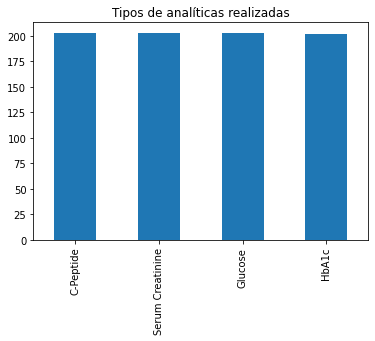

In [17]:
data1['ResultName'].value_counts().plot.bar(title="Tipos de analíticas realizadas")

In [18]:
data1['Analyte'].value_counts()

CPEP      203
CREA-S    203
GLU       203
HBA1C     202
Name: Analyte, dtype: int64

Vemos que hay un paciente que no tiene hecha la analítica de HBA1C

Podemos ver que hay 4 tipos de analíticas diferentes y además, todas ellas están balanceadas, por lo que a todos los pacientes presentes en el estudio se les han hecho los 4 tipos de analíticas menos uno de ellos

A continuación, eliminaremos la columna ResultName, ya que ya tenemos el nombre de la analítica en la columna Analyte:

In [19]:
data1.drop(['ResultName'], axis=1, inplace=True)

In [20]:
data1.head()

,PtID,Analyte,Value,Units
0,33,CPEP,<0.017,nmol/L
1,36,CREA-S,1.19,mg/dL
2,33,HBA1C,7.9,NaN
3,36,HBA1C,7.8,NaN
4,33,CREA-S,1.01,mg/dL


In [21]:
data1[data1['Analyte']=='HBA1C']['Units'].value_counts()

Series([], Name: Units, dtype: int64)

In [22]:
data1[data1['Analyte']=='CREA-S']['Units'].value_counts()

mg/dL    203
Name: Units, dtype: int64

In [23]:
data1[data1['Analyte']=='CPEP']['Units'].value_counts()

nmol/L    203
Name: Units, dtype: int64

In [24]:
data1[data1['Analyte']=='GLU']['Units'].value_counts()

mg/dL    203
Name: Units, dtype: int64

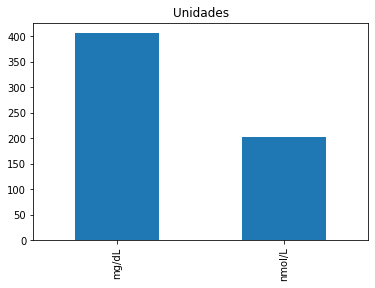

In [25]:
data1['Units'].value_counts().plot.bar(title="Unidades")

Podemos ver que cada una de las analíticas por separado presentan las mismas unidades, por lo que es una columna que se puede eliminar

También eliminamos la columna de unidades, ya que cada uno de los valores (en correspondencia con su tipo de analítica) presenta el mismo tipo de unidad)

In [26]:
data1.drop(['Units'], axis=1, inplace=True)

También vamos a quitar el < de valor, y lo dejaremos con el valor asignado a la derecha:

In [27]:
data1["Value"] = data1["Value"].replace({'<':''}, regex=True)


In [28]:
data1.head()

,PtID,Analyte,Value
0,33,CPEP,0.017
1,36,CREA-S,1.19
2,33,HBA1C,7.9
3,36,HBA1C,7.8
4,33,CREA-S,1.01


In [29]:
data1.dtypes

PtID        int64
Analyte    object
Value      object
dtype: object

Como considera Value como un object lo vamos a transformar a un tipo float:

In [30]:
data1['Value']=data1['Value'].astype(str).astype(float)


In [31]:
data1.dtypes

PtID         int64
Analyte     object
Value      float64
dtype: object

A continuación, procedemos a crear una columna por tipo de analítica realizada para que así no aparezcan múltiples instancias de un mismo paciente, consiguiendo así que aparezca un solo registro por paciente:

In [32]:

HB=data1['Analyte']=='HBA1C'
data_HBA1C=data1[HB]
data_HBA1C.drop(['Analyte'], axis=1, inplace=True)
data_HBA1C = data_HBA1C.rename(columns={'Value':'Value_HBA1C'})

CP=data1['Analyte']=='CPEP'
data_CPEP=data1[CP]
data_CPEP.drop(['Analyte'], axis=1, inplace=True)
data_CPEP = data_CPEP.rename(columns={'Value':'Value_CPEP'})

CR=data1['Analyte']=='CREA-S'
data_CREAS=data1[CR]
data_CREAS.drop(['Analyte'], axis=1, inplace=True)
data_CREAS = data_CREAS.rename(columns={'Value':'Value_CREAS'})

GLU=data1['Analyte']=='GLU'
data_GLU=data1[GLU]
data_GLU.drop(['Analyte'], axis=1, inplace=True)
data_GLU = data_GLU.rename(columns={'Value':'Value_GLU'})

data_final=data_HBA1C.merge(data_CPEP, on='PtID').merge(data_CREAS, on='PtID').merge(data_GLU, on='PtID').merge(data_out, on='PtID')
data_final

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,PtID,Value_HBA1C,Value_CPEP,Value_CREAS,Value_GLU,BCaseControlStatus
0,33,7.9,0.017,1.01,213.0,0
1,36,7.8,0.017,1.19,157.0,1
2,48,6.6,0.017,1.17,83.0,1
3,125,8.6,0.017,0.90,103.0,1
4,40,8.7,0.017,0.74,166.0,1
...,...,...,...,...,...,...
218,46,8.0,0.017,0.87,283.0,1
219,133,6.8,0.017,1.26,141.0,1
220,180,6.7,0.017,0.68,126.0,1
221,179,6.9,0.017,0.76,308.0,1


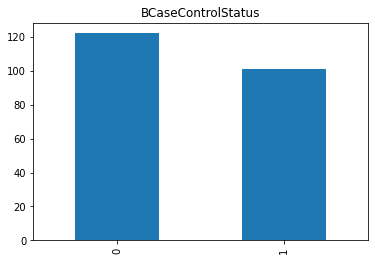

In [33]:
data_final['BCaseControlStatus'].value_counts().plot.bar(title="BCaseControlStatus")

Ahora eliminaremos ya la columna PtID, ya que ya hemos conseguido lo que queríamos con ella y no necesitamos nada más 

In [34]:
data_final.drop(['PtID'], axis=1, inplace=True)



In [35]:
data_final.head()

,Value_HBA1C,Value_CPEP,Value_CREAS,Value_GLU,BCaseControlStatus
0,7.9,0.017,1.01,213.0,0
1,7.8,0.017,1.19,157.0,1
2,6.6,0.017,1.17,83.0,1
3,8.6,0.017,0.90,103.0,1
4,8.7,0.017,0.74,166.0,1


In [36]:
data_final['Value_GLU'].max()

543.0

In [39]:
data_final.columns

Index(['Value_HBA1C', 'Value_CPEP', 'Value_CREAS', 'Value_GLU',
       'BCaseControlStatus'],
      dtype='object')

In [40]:
data_final.dtypes

Value_HBA1C           float64
Value_CPEP            float64
Value_CREAS           float64
Value_GLU             float64
BCaseControlStatus      int64
dtype: object

# ***CÓDIGO GRÁFICAS TFG***

In [43]:
# print(high.shape,high2.shape)

list_num_features=['Value_HBA1C', 'Value_CREAS', 'Value_GLU','Value_CPEP']

In [44]:
# fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for column_name in list_num_features:
  high=data_final[data_final.loc[:,'BCaseControlStatus']=='Case'].loc[:,column_name]
  high2=data_final[data_final.loc[:,'BCaseControlStatus']=='Control'].loc[:,column_name]
  plt.hist([high, high2], bins=30, label=['Caso', 'Control'])
  # plt.legend(loc='upper left')
  # plt.xlim([0, 0.2])
  plt.rcParams["figure.figsize"] = (5, 3)
  # plt.show()
  plt.savefig("{}.pdf".format(column_name))
  plt.close()

# ***Visualización de datos***

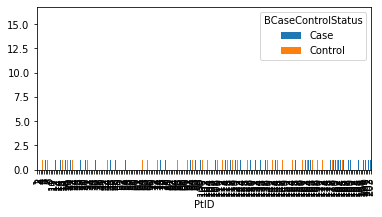

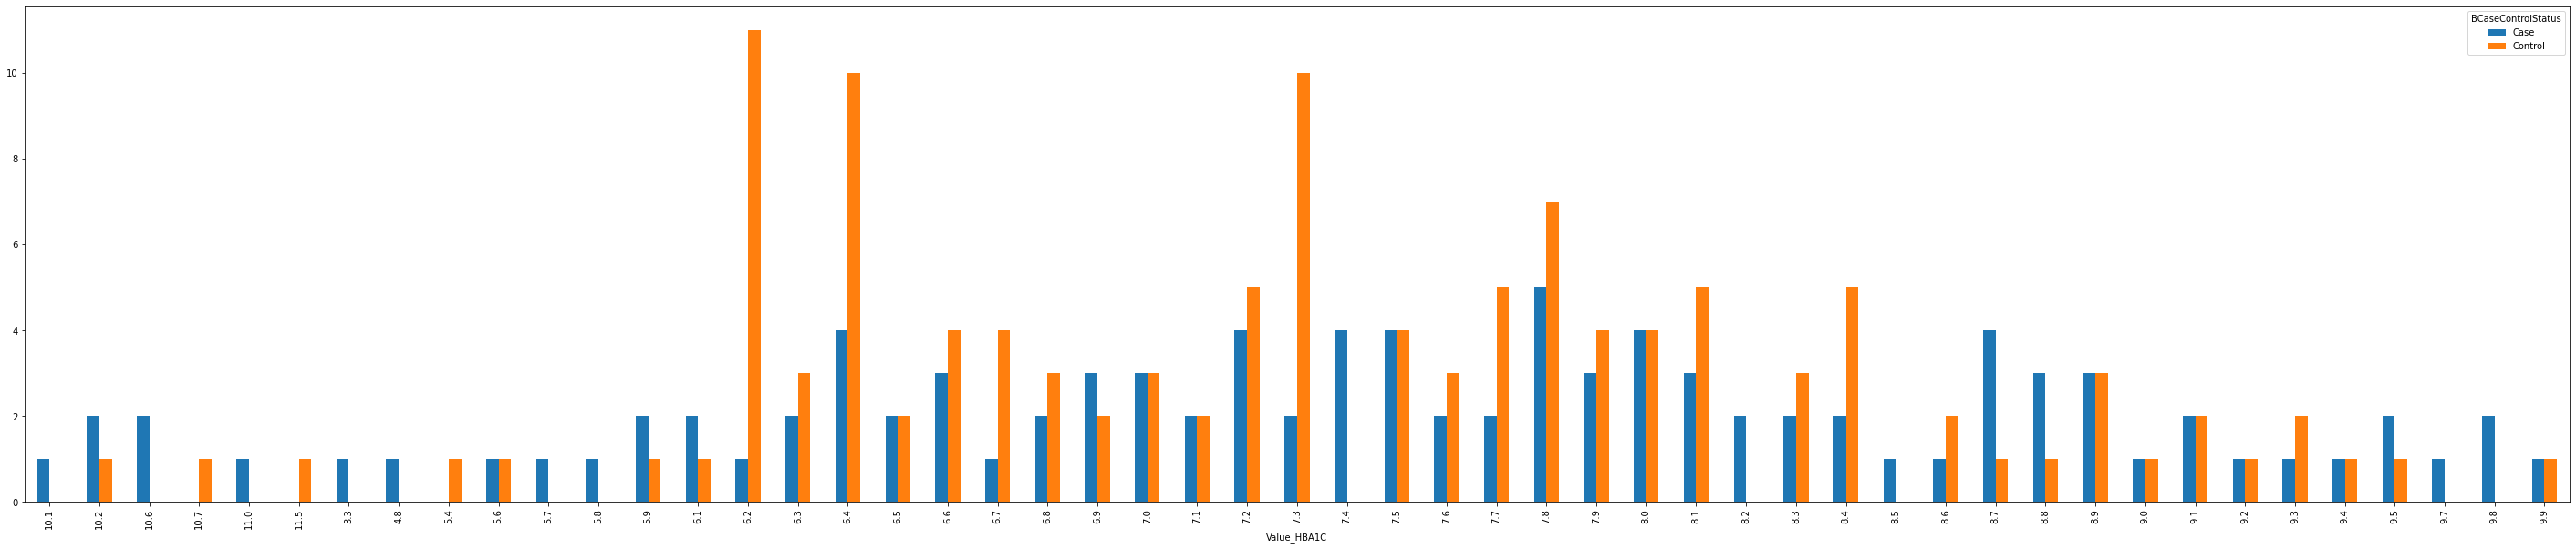

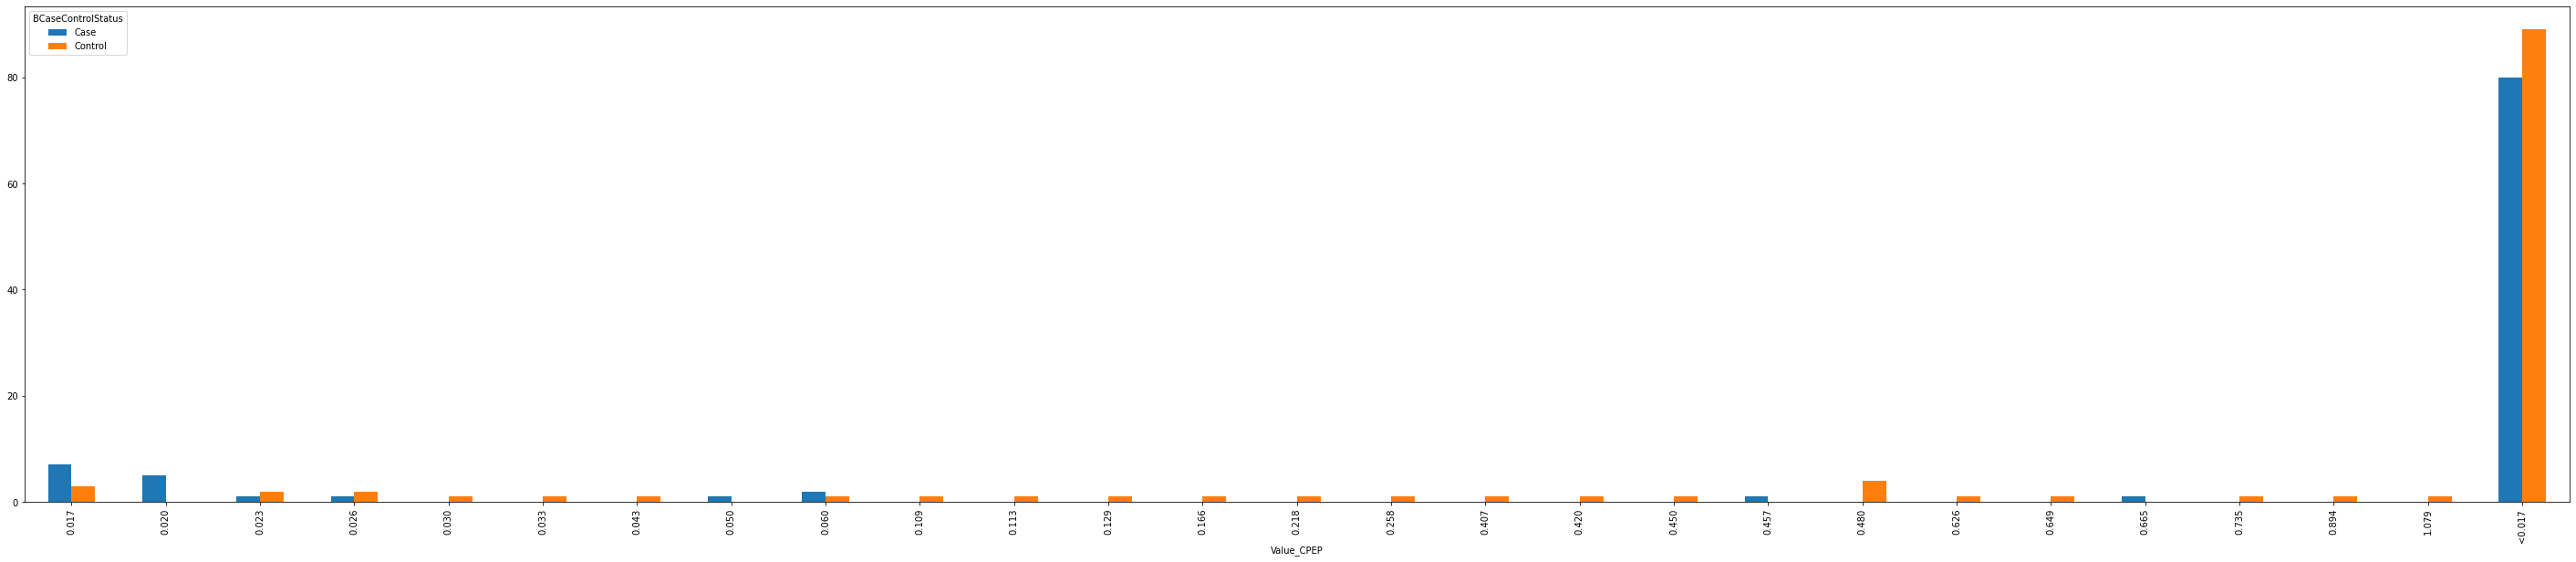

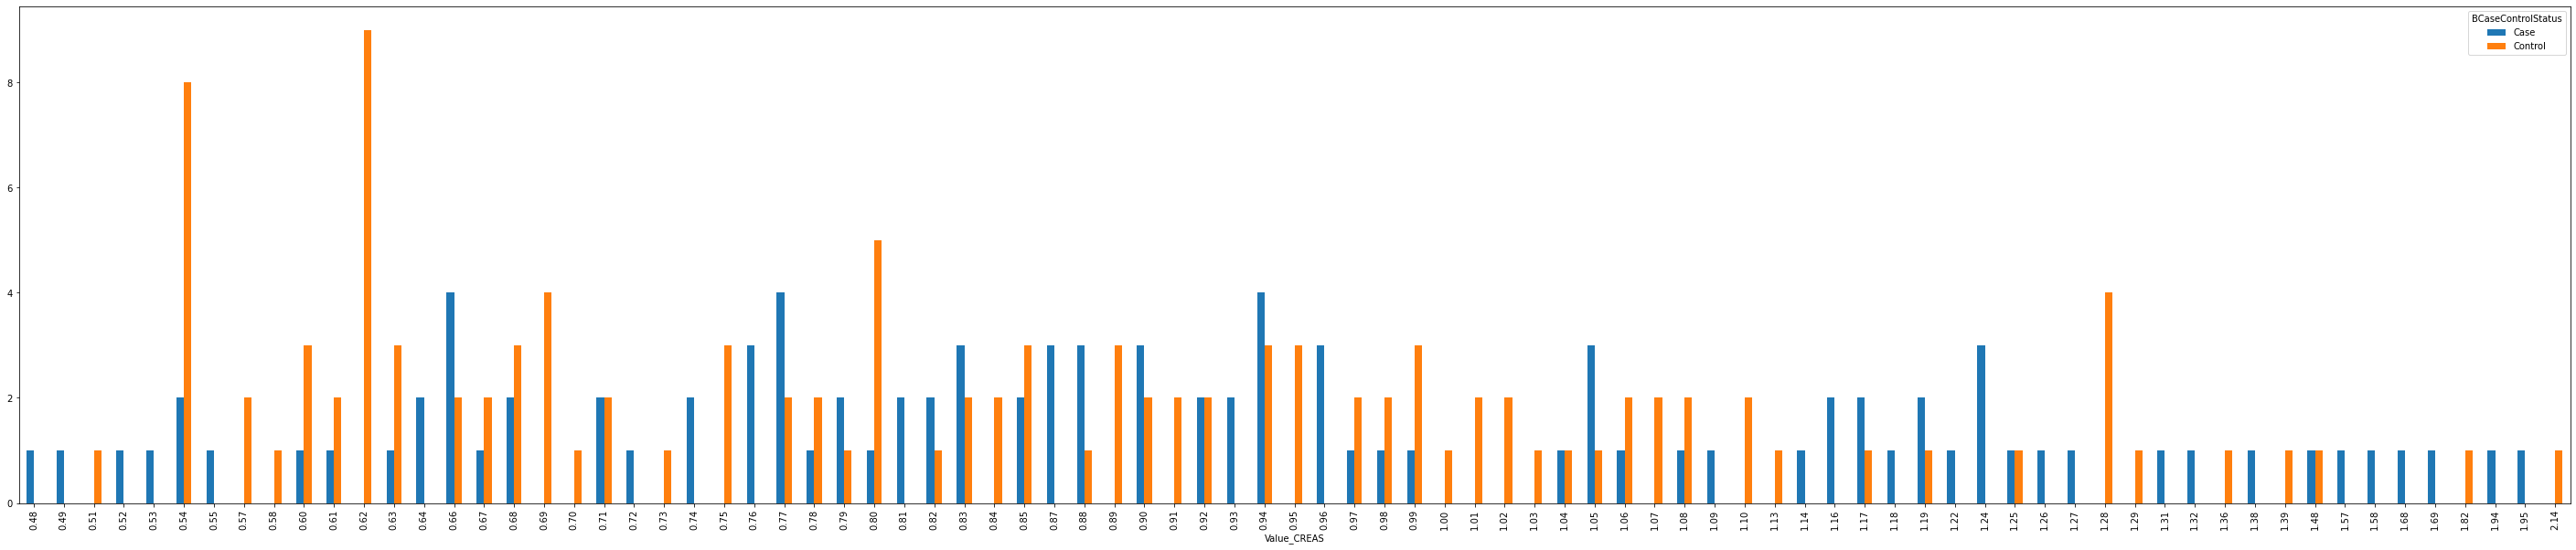

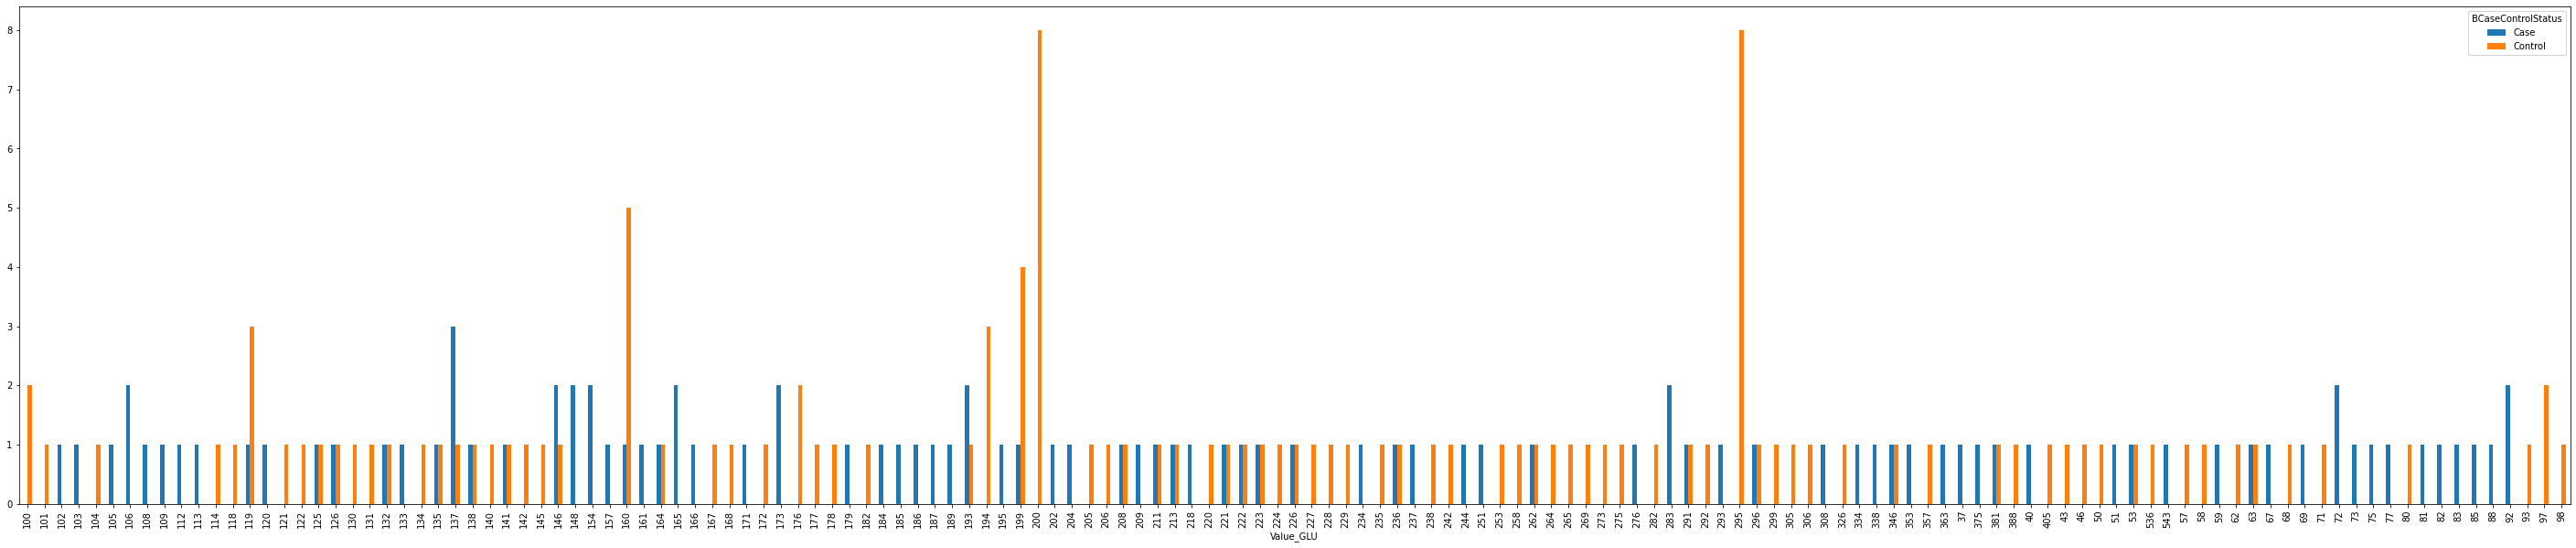

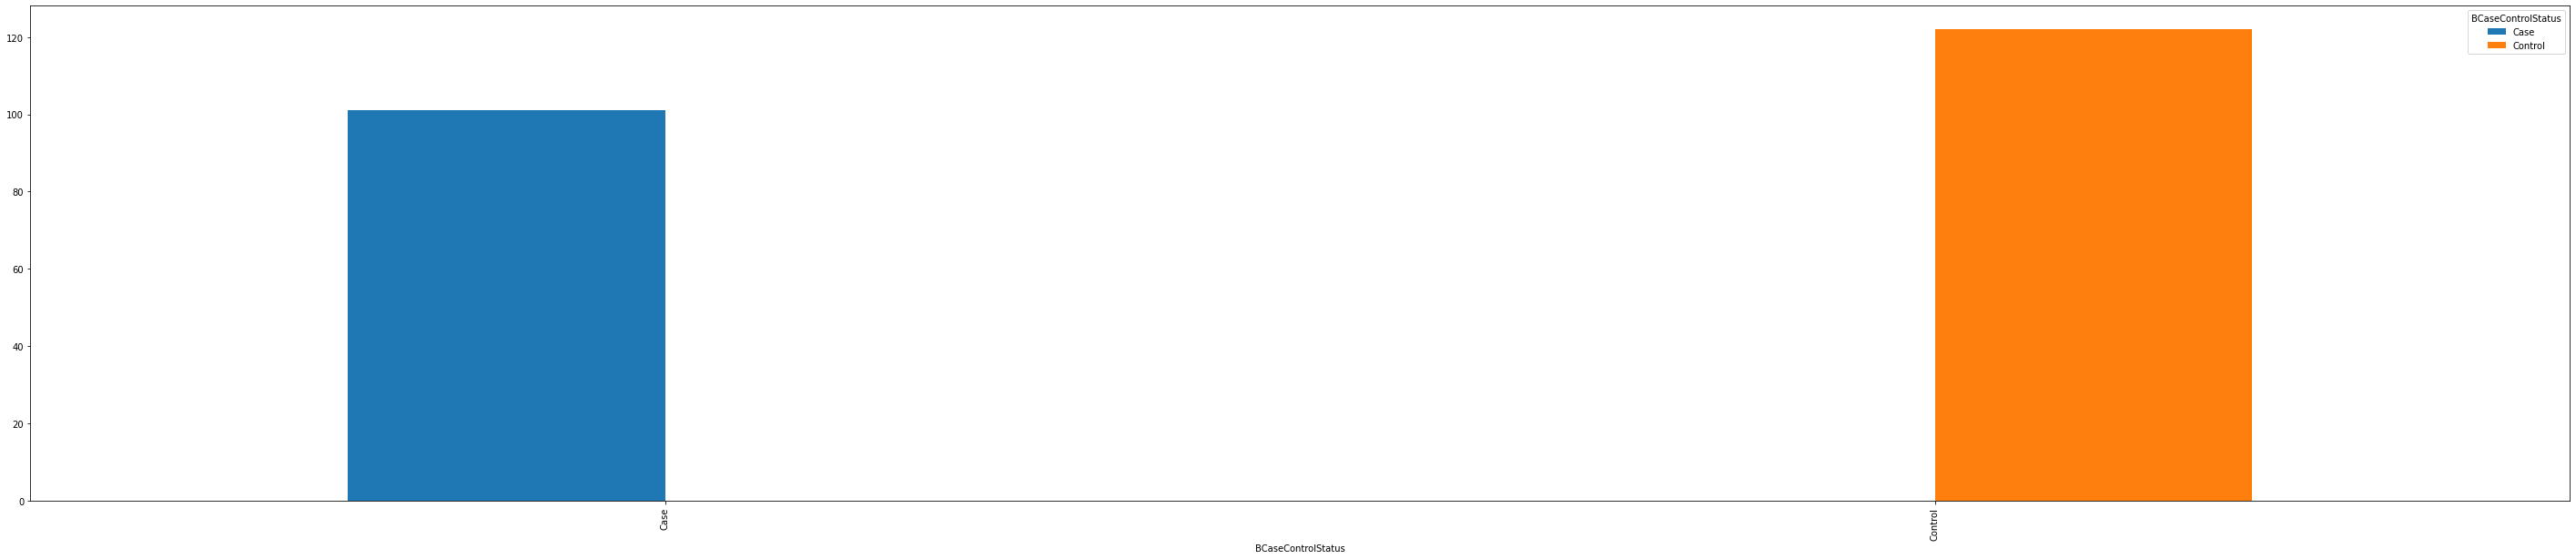

In [ ]:
for i in data_final:
#   # if data[i].dtypes!='object':
  plot=pd.crosstab(index=data_final[i], columns=data_final['BCaseControlStatus']).apply(lambda r : r, axis=1).plot(kind='bar',layout=(4,4))
  plt.rcParams["figure.figsize"] = (50, 10)

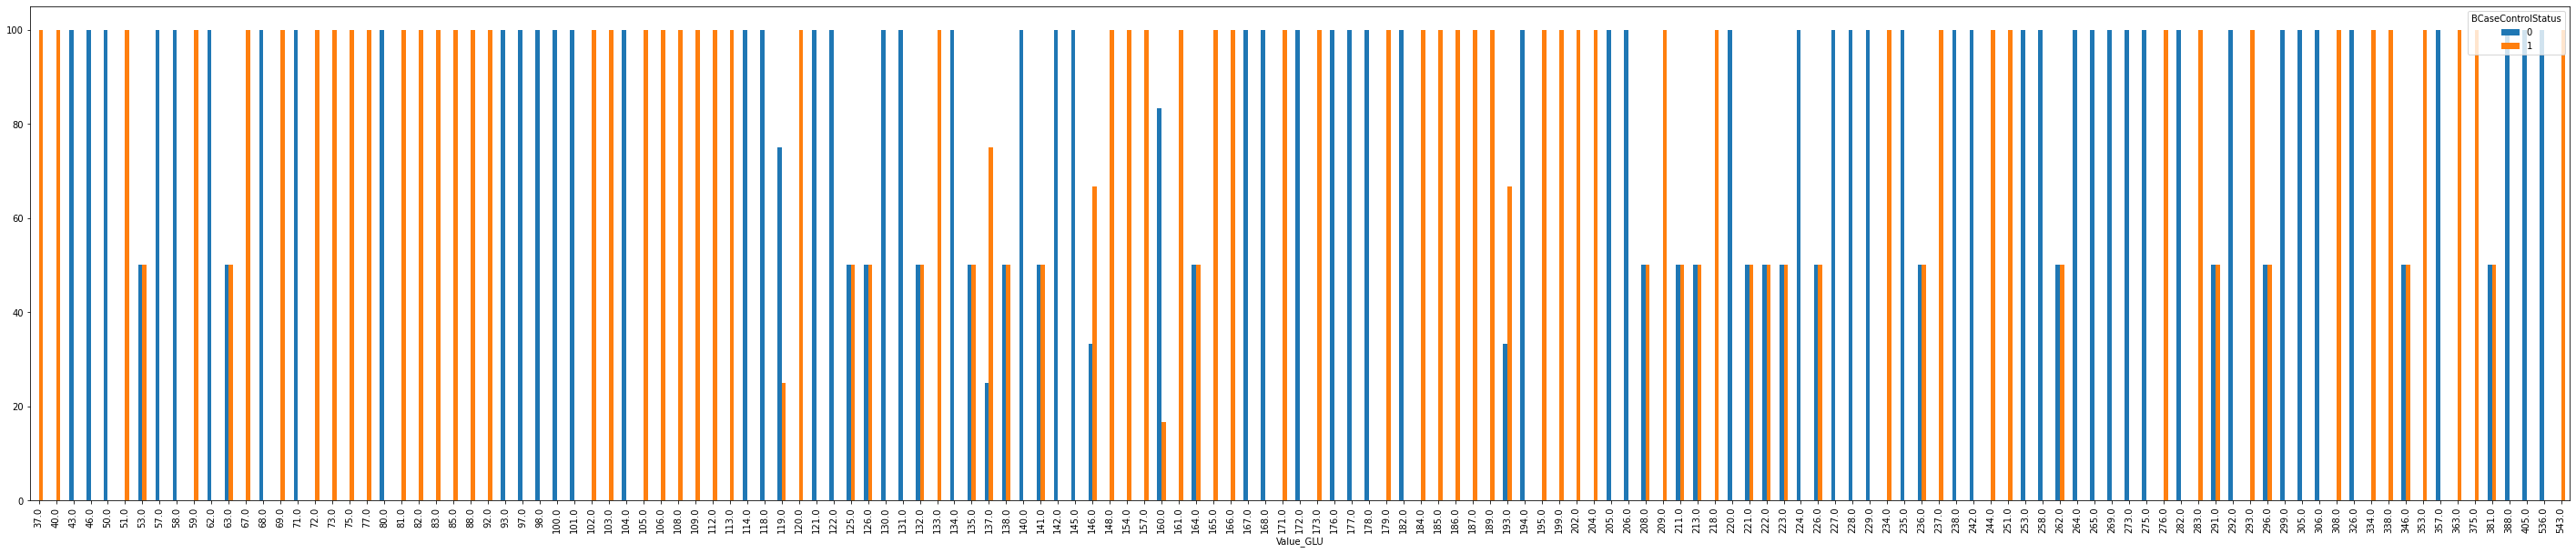

In [ ]:
plot=pd.crosstab(index=data_final['Value_GLU'], columns=data_final['BCaseControlStatus']).apply(lambda r : r/r.sum()*100, axis=1).plot(kind='bar')
plt.rcParams["figure.figsize"] = (50, 10)

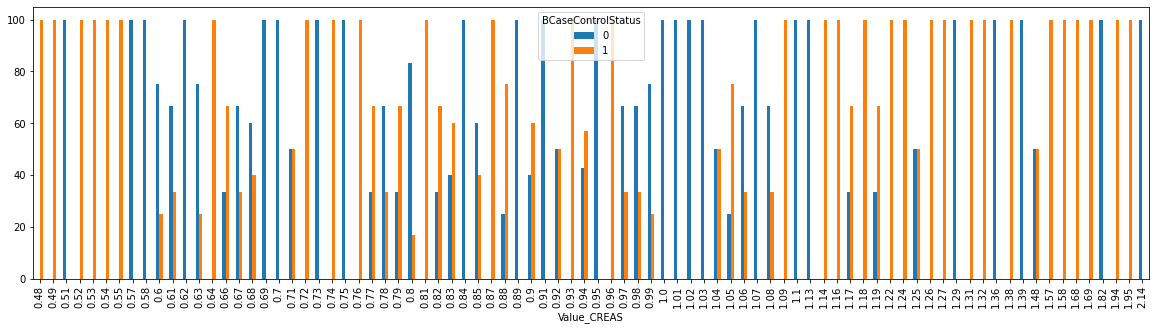

In [ ]:
plot=pd.crosstab(index=data_final['Value_CREAS'], columns=data_final['BCaseControlStatus']).apply(lambda r : r/r.sum()*100, axis=1).plot(kind='bar')
plt.rcParams["figure.figsize"] = (20, 10)

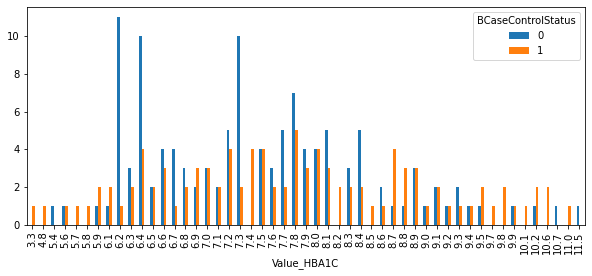

In [ ]:
plot=pd.crosstab(index=data_final['Value_HBA1C'], columns=data_final['BCaseControlStatus']).apply(lambda r : r, axis=1).plot(kind='bar')
plt.rcParams["figure.figsize"] = (20, 10)

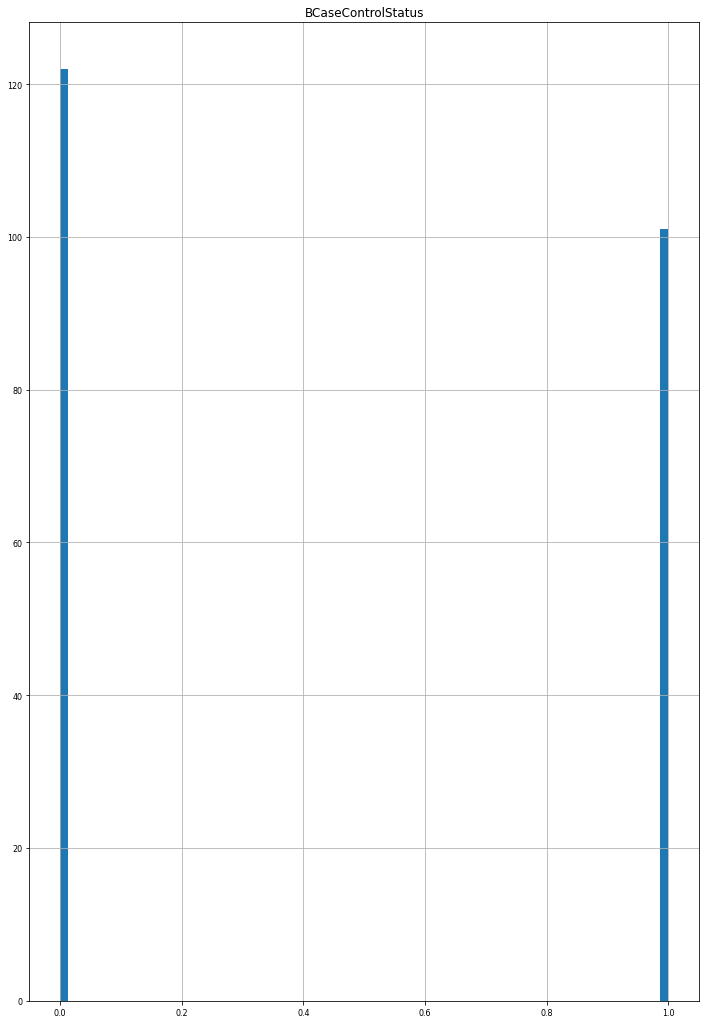

In [ ]:
# Histogram
data_final.hist(figsize=(12, 18), bins=70, xlabelsize=8, ylabelsize=8); 

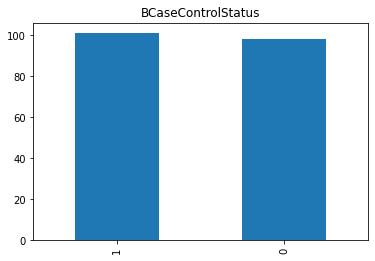

In [ ]:
data_final['BCaseControlStatus'].value_counts().plot.bar(title="BCaseControlStatus")

A continuación, vamos a visualizar como se distribuyen los distintos valores de las analíticas según sean paciente caso o control:

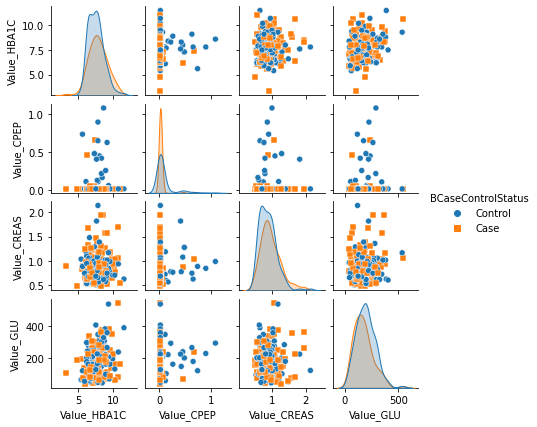

In [ ]:
sns.pairplot(data_final, hue = 'BCaseControlStatus', markers=["o", "s"], height=1.5)

# ***Preprocesado de datos***

# ***Valores perdidos***

In [ ]:
(data_final == 0).sum(axis=0)

PtID                    0
Value_HBA1C             0
Value_CPEP              5
Value_CREAS             0
Value_GLU               0
BCaseControlStatus    122
dtype: int64

Los ceros que aparecen son los correspondientes a la variable binaria de los pacientes caso-control

In [ ]:
data_final.isna().sum()

PtID                  0
Value_HBA1C           0
Value_CPEP            0
Value_CREAS           6
Value_GLU             6
BCaseControlStatus    0
dtype: int64

Vemos que hay algunos valores nulos en las diferentes variables


In [ ]:
!pip install missingno




In [ ]:
import missingno as msno

In [ ]:
msno.__version__

'0.5.1'

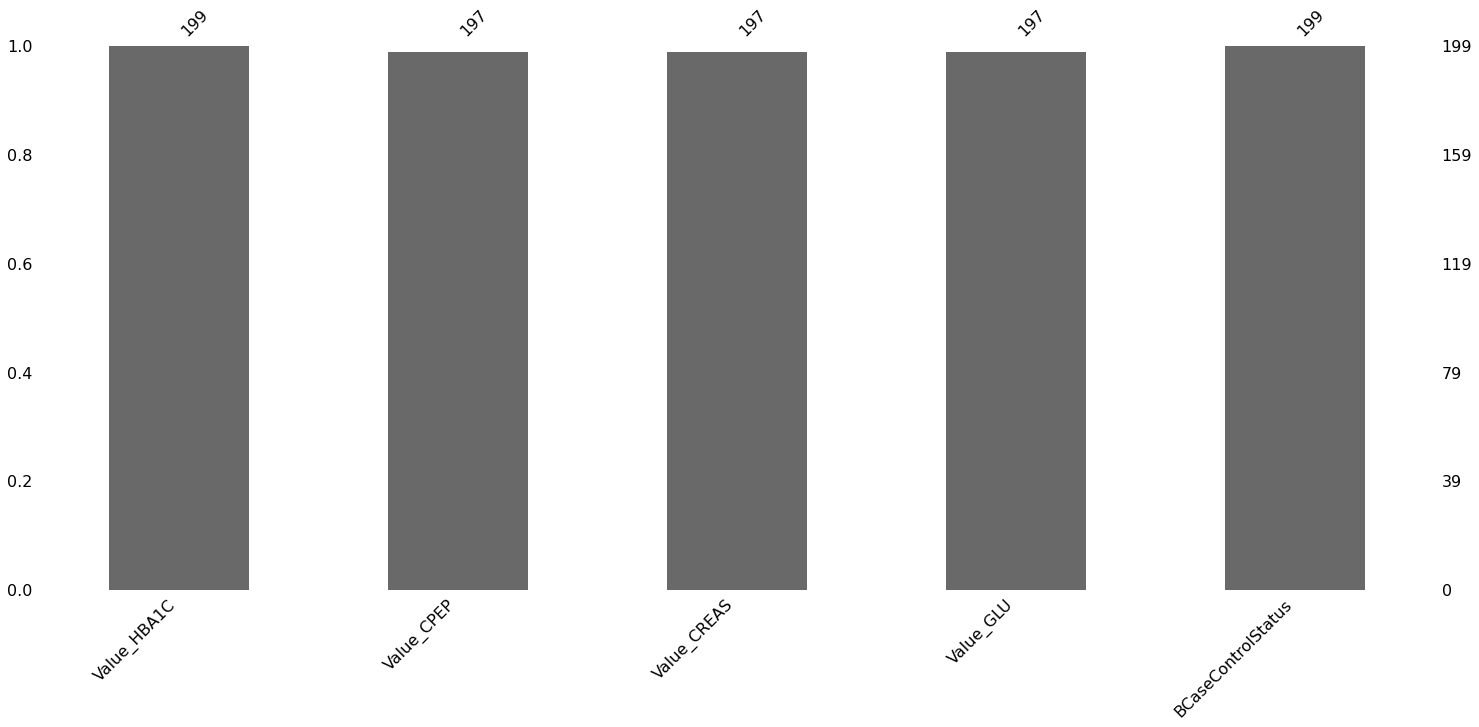

In [ ]:
msno.bar(data_final)

Graficamos a continuación a partir de un mapa de color como se están comportando esos valores NaN en las distintas variables y pacientes:

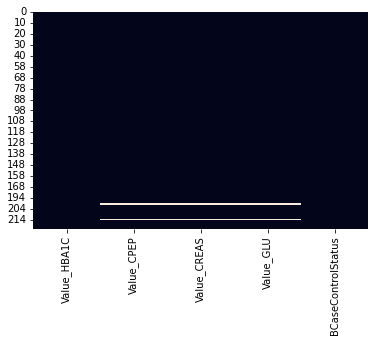

In [ ]:
import seaborn as sns

# Identificamos los missing values visualmente
sns.heatmap(data_final.isnull(), cbar=False)

Aquí podemos ver que existen algunos valores nulos, pero si eliminamos ahora el registro si que estaríamos eliminando más información, ya que estaríamos quitándonos información de varias variables, por lo que esos valores nulos los trataremos de suplentar con la media por ejemplo. Esto se hará una vez se divida en entrenamiento y test.

# ***Outliers***

Para ver si la base de datos presenta o no outliers, me ayudaré a partir de la visualización de los diagramas de cajas:

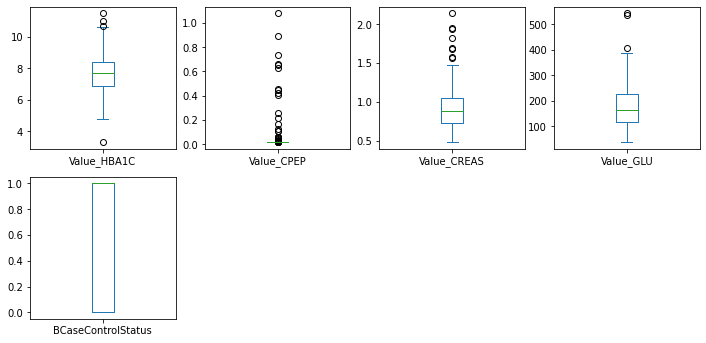

In [ ]:
data_final.plot(kind='box',subplots=True, layout=(4,4), sharex=False, sharey=False, figsize=(12,12))
plt.show()

A la vista de los resultados, podemos concluir que los valores atípicos que aparece podrían ser realmente puntuaciones obtenidas por los pacientes, y sernos de utilidad a la hora del diseño del modelo.

# ***Matriz de correlación***

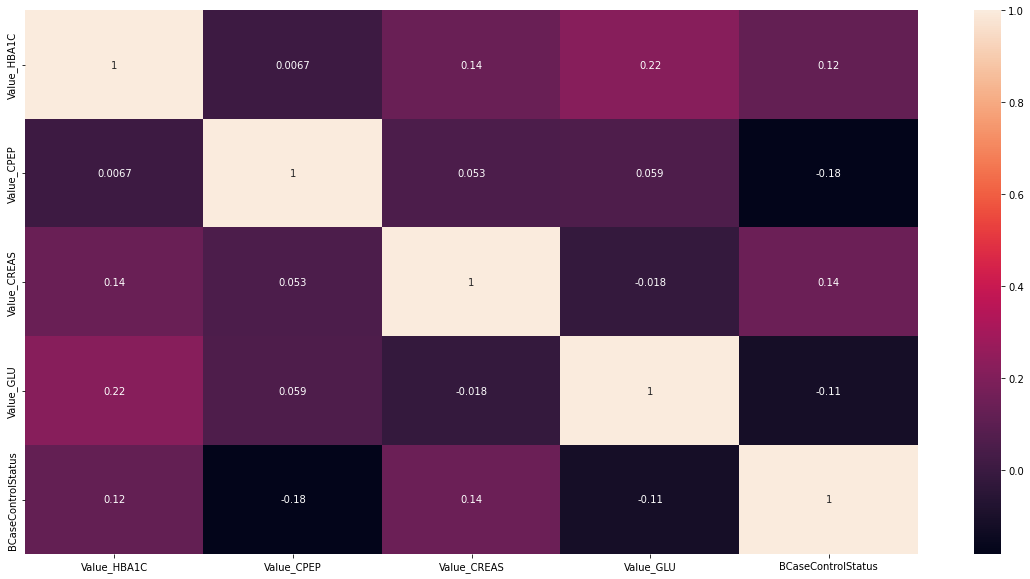

In [ ]:
f, ax = plt.subplots(figsize=(20, 10))
corr = data_final.corr()
sns.heatmap(corr,annot=True,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [ ]:
data_final.drop(['Value_CPEP'], axis=1, inplace=True)


# ***Validación cruzada***

In [45]:
X = data_final.loc[:, data_final.columns != 'BCaseControlStatus']
Y= data_final["BCaseControlStatus"]


In [48]:
from sklearn.svm import SVC

In [49]:
# Regresión logística con regularización 
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection   
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV

def regresion_logistica(X_train, X_test, Y_train, Y_test,semilla):
  logreg= LogisticRegression(solver='liblinear',random_state=semilla)
  parameters = {"C":[1e-8,1e-7,1e-6,1e-5,1e-4,1,10,20, 30,40,50,100],"penalty":["l1"]}# l1 lasso l2 ridge
  valor_C=np.array([1e-8,1e-4,1,10,20,30,40,50,100])
  log_regression=GridSearchCV(logreg, parameters, scoring='accuracy', cv=5, return_train_score=True)

  log_regression.fit(X_train, Y_train) #Entrenamos

  # #Evaluamos las prestaciones para el conjunto de entrenamiento, de validación y representamos
  roc_log_train = np.array(log_regression.cv_results_['mean_train_score']) 
  roc_loc_val = np.array(log_regression.cv_results_['mean_test_score'])

    # Mostramos el mejor valor del parámetro y el score
  print("Valor correspondiente para el hiperparámetro: {}".format(log_regression.best_params_))
  print("Mayor valor de la figura de mérito en validación con características estandarizadas: {:.3f}".format(log_regression.best_score_))

# 2. Consulta de los valores de los hiper-parámetros utilizados en la creación del árbol
  log_regression.get_params()

  # 3. Se entrena el modelo con los mejores valores de los hiperparámetros y se obtienen las prestaciones en la partición de test
  regre_clasif = log_regression.best_estimator_
  modelo_regresion = regre_clasif.fit(X_train, Y_train)

  y_output_regresion = modelo_regresion.predict(X_test)
  print(accuracy_score(Y_test, y_output_regresion))
  print(confusion_matrix(Y_test, y_output_regresion))
  tn, fp, fn, tp = confusion_matrix(Y_test, y_output_regresion).ravel()
  Especificidad = tn / (tn + fp)
  Recall= recall_score(Y_test, y_output_regresion)
  Accuracy = accuracy_score(Y_test, y_output_regresion)
  Precision=precision_score(Y_test, y_output_regresion)
  f1=f1_score(Y_test, y_output_regresion)
  print("Sensibilidad, Accuracy, Especificidad, f1-score",Recall, Accuracy,Especificidad,f1)

  fpr, tpr, threshold = metrics.roc_curve(Y_test, y_output_regresion)
  roc_auc = metrics.auc(fpr, tpr)

  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

  return (Recall, Accuracy, Especificidad, f1, roc_auc)




In [50]:
from sklearn.tree import DecisionTreeClassifier
# Comenzamos importando los paquetes básicos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn import metrics
from sklearn.neural_network import MLPRegressor

def decisionTree(X_train, X_test, Y_train, Y_test,semilla):

  # 1. Selección de hiper-parámetros del árbol. En principio, consideraremos sólo la profundidad máxima
  param_grid = {'max_depth': range(1,5), 'min_samples_leaf': range(5,50)}
  profundidad_grid = np.array(range(1,5))

  # X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size = 0.2, random_state=2)
  grid_arbol_clasif = GridSearchCV(DecisionTreeClassifier(random_state=semilla), param_grid = param_grid, scoring = 'accuracy', cv=3, return_train_score=True)
  grid_arbol_clasif.fit(X_train, Y_train)
  print(grid_arbol_clasif.best_params_)

  # perf_train_arbol = np.array(grid_arbol_clasif.cv_results_['mean_train_score'])
  # perf_val_arbol = np.array(grid_arbol_clasif.cv_results_['mean_test_score'])

  # plt.plot(profundidad_grid,perf_train_arbol,'-o',label="train", linewidth=2)
  # plt.plot(profundidad_grid,perf_val_arbol,'-*b',label="val", linewidth=2)
  # plt.xlabel('Profundidad',fontsize=14)
  # plt.ylabel('ROC-AUC',fontsize=14)
  # plt.legend()
  # plt.show()

  print("Mejor ROC-AUC en validación cruzada: {:.3f}".format(grid_arbol_clasif.best_score_))
  print("Mejor valor del hiperparámetro: {}".format(grid_arbol_clasif.best_params_))

  # 2. Consulta de los valores de los hiper-parámetros utilizados en la creación del árbol
  grid_arbol_clasif.get_params()

  # 3. Se entrena el modelo con los mejores valores de los hiperparámetros y se obtienen las prestaciones en la partición de test
  Arbol_clasif_all = grid_arbol_clasif.best_estimator_
  modelo_arbol_clasif = Arbol_clasif_all.fit(X_train, Y_train)

  y_output_arbol = modelo_arbol_clasif.predict(X_test)
  print(accuracy_score(Y_test, y_output_arbol))
  print(confusion_matrix(Y_test, y_output_arbol))
  tn, fp, fn, tp = confusion_matrix(Y_test, y_output_arbol).ravel()
  Especificidad = tn / (tn + fp)
  Recall= recall_score(Y_test, y_output_arbol)
  Accuracy = accuracy_score(Y_test, y_output_arbol)
  Precision=precision_score(Y_test, y_output_arbol)
  f1=f1_score(Y_test, y_output_arbol)
  print("Sensibilidad, Accuracy, Especifididad, f1-score",Recall, Accuracy,Especificidad,f1)

  fpr, tpr, threshold = metrics.roc_curve(Y_test, y_output_arbol)
  roc_auc = metrics.auc(fpr, tpr)

  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

  return (Recall, Accuracy, Especificidad, f1, roc_auc)

In [51]:
def knn (X_train,X_test,Y_train,Y_test):
  # 5. Selección del hiper-parámetro haciendo uso del conjunto de diseño con características estandarizadas. 

  param_grid = {'n_neighbors': range(1,81,2)}
  k_grid = np.array(range(1,81,2))
  grid_knn = GridSearchCV(KNeighborsClassifier(metric='euclidean'), param_grid = param_grid, scoring = 'accuracy', cv=3, return_train_score=True)
  grid_knn.fit(X_train, Y_train) 

  #Evaluamos las prestaciones para el conjunto de entrenamiento, de validación y representamos
  
  auc_knn_all_train = np.array(grid_knn.cv_results_['mean_train_score'])
  auc_knn_all_val = np.array(grid_knn.cv_results_['mean_test_score'])


  plt.plot(k_grid,auc_knn_all_train,'-o',label="train", linewidth=2)
  plt.plot(k_grid,auc_knn_all_val,'-*b',label="val", linewidth=2)
  plt.xlabel('k',fontsize=14)
  plt.ylabel('roc_auc',fontsize=14)
  plt.legend()
  plt.show()

  print("Mayor valor de la figura de mérito en validación con características estandarizadas: {:.3f}".format(grid_knn.best_score_))
  print("Valor correspondiente para el hiperparámetro: {}".format(grid_knn.best_params_))

  # 2. Consulta de los valores de los hiper-parámetros utilizados en la creación del árbol
  grid_knn.get_params()

  # 3. Se entrena el modelo con los mejores valores de los hiperparámetros y se obtienen las prestaciones en la partición de test
  kNN_clasif_all = grid_knn.best_estimator_
  modelo_knn_clasif2 = kNN_clasif_all.fit(X_train, Y_train)

  y_output_knn2 = modelo_knn_clasif2.predict(X_test)
  print(accuracy_score(Y_test, y_output_knn2))
  print(confusion_matrix(Y_test, y_output_knn2))
  tn, fp, fn, tp = confusion_matrix(Y_test, y_output_knn2).ravel()
  Especificidad = tn / (tn + fp)

  Recall= recall_score(Y_test, y_output_knn2)
  Accuracy = accuracy_score(Y_test, y_output_knn2)
  Precision=precision_score(Y_test, y_output_knn2)
  f1=f1_score(Y_test, y_output_knn2)
  print("Sensibilidad, Accuracy, Especificidad, f1-score",Recall, Accuracy,Especificidad,f1)

  fpr, tpr, threshold = metrics.roc_curve(Y_test, y_output_knn2)
  roc_auc = metrics.auc(fpr, tpr)

  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],
           'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

  return (Recall, Accuracy, Especificidad, f1, roc_auc)

In [52]:
def svc (X_train,X_test,Y_train,Y_test,semilla):
  # 5. Selección del hiper-parámetro haciendo uso del conjunto de diseño con características estandarizadas. 
  svc=SVC(decision_function_shape='ovo',random_state=semilla)
  parameters = {'kernel': ['rbf'], 'gamma': [1e-2, 1e-3, 1e-4, 1e-5],
                      'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]}

  svc=GridSearchCV(svc, parameters, scoring='accuracy', cv=5, return_train_score=True)

  svc.fit(X_train, Y_train) #Entrenamos

  # #Evaluamos las prestaciones para el conjunto de entrenamiento, de validación y representamos
  roc_svc_train = np.array(svc.cv_results_['mean_train_score']) 
  roc_svc_val = np.array(svc.cv_results_['mean_test_score'])

  # Mostramos el mejor valor del parámetro y el score
  print("Valor correspondiente para el hiperparámetro: {}".format(svc.best_params_))
  print("Mayor valor de la figura de mérito en validación con características estandarizadas: {:.3f}".format(svc.best_score_))

  # 2. Consulta de los valores de los hiper-parámetros 
  svc.get_params()

  # 3. Se entrena el modelo con los mejores valores de los hiperparámetros y se obtienen las prestaciones en la partición de test
  svc_classif = svc.best_estimator_
  modelo_svc = svc_classif.fit(X_train, Y_train)

  y_output_svc = modelo_svc.predict(X_test)
  print(accuracy_score(Y_test, y_output_svc))
  print(confusion_matrix(Y_test, y_output_svc))
  tn, fp, fn, tp = confusion_matrix(Y_test, y_output_svc).ravel()
  Especificidad = tn / (tn + fp)
  Recall= recall_score(Y_test, y_output_svc)
  Accuracy = accuracy_score(Y_test, y_output_svc)
  Precision=precision_score(Y_test, y_output_svc)
  f1=f1_score(Y_test, y_output_svc)
  print("Sensibilidad, Accuracy, Especificidad, f1-score",Recall, Accuracy,Especificidad,f1)

  fpr, tpr, threshold = metrics.roc_curve(Y_test, y_output_svc)
  roc_auc = metrics.auc(fpr, tpr)

  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

  return (Recall, Accuracy, Especificidad, f1, roc_auc)

In [53]:
def svc_lineal (X_train,X_test,Y_train,Y_test,semilla):
  # 5. Selección del hiper-parámetro haciendo uso del conjunto de diseño con características estandarizadas. 
  svc=SVC(decision_function_shape='ovo',random_state=semilla)
  parameters = {'kernel': ['linear'], 'gamma': [1e-2, 1e-3, 1e-4, 1e-5],
                      'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]}

  svc=GridSearchCV(svc, parameters, scoring='accuracy', cv=5, return_train_score=True)

  svc.fit(X_train, Y_train) #Entrenamos

  # #Evaluamos las prestaciones para el conjunto de entrenamiento, de validación y representamos
  roc_svc_train = np.array(svc.cv_results_['mean_train_score']) 
  roc_svc_val = np.array(svc.cv_results_['mean_test_score'])

  # Mostramos el mejor valor del parámetro y el score
  print("Valor correspondiente para el hiperparámetro: {}".format(svc.best_params_))
  print("Mayor valor de la figura de mérito en validación con características estandarizadas: {:.3f}".format(svc.best_score_))

  # 2. Consulta de los valores de los hiper-parámetros 
  svc.get_params()

  # 3. Se entrena el modelo con los mejores valores de los hiperparámetros y se obtienen las prestaciones en la partición de test
  svc_classif = svc.best_estimator_
  modelo_svc = svc_classif.fit(X_train, Y_train)

  y_output_svc = modelo_svc.predict(X_test)
  print(accuracy_score(Y_test, y_output_svc))
  print(confusion_matrix(Y_test, y_output_svc))
  tn, fp, fn, tp = confusion_matrix(Y_test, y_output_svc).ravel()
  Especificidad = tn / (tn + fp)
  Recall= recall_score(Y_test, y_output_svc)
  Accuracy = accuracy_score(Y_test, y_output_svc)
  Precision=precision_score(Y_test, y_output_svc)
  f1=f1_score(Y_test, y_output_svc)
  print("Sensibilidad, Accuracy, Especificidad, f1-score",Recall, Accuracy,Especificidad,f1)

  fpr, tpr, threshold = metrics.roc_curve(Y_test, y_output_svc)
  roc_auc = metrics.auc(fpr, tpr)

  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

  return (Recall, Accuracy, Especificidad, f1, roc_auc)

In [58]:
list_x_train = []
list_y_train = []
list_x_test = []
list_y_test = []

#LISTAS PARA STANDARD SCALER
recall_reg_std = []
accuracy_reg_std = []
precision_reg_std=[]
f1_reg_std=[]
roc_reg_std= []

recall_arbol_std = []
accuracy_arbol_std = []
precision_arbol_std=[]
f1_arbol_std=[]
roc_arbol_std= []

recall_knn_std = []
accuracy_knn_std = []
precision_knn_std=[]
f1_knn_std=[]
roc_knn_std= []

recall_svc_std = []
accuracy_svc_std = []
precision_svc_std=[]
f1_svc_std=[]
roc_svc_std= []

recall_svc_lin_std = []
accuracy_svc_lin_std = []
precision_svc_lin_std=[]
f1_svc_lin_std=[]
roc_svc_lin_std= []

#LISTAS PARA MIN-MAX

recall_reg_scaler = []
accuracy_reg_scaler = []
precision_reg_scaler=[]
f1_reg_scaler=[]
roc_reg_scaler= []

recall_arbol_scaler = []
accuracy_arbol_scaler = []
precision_arbol_scaler=[]
f1_arbol_scaler=[]
roc_arbol_scaler= []

recall_knn_scaler = []
accuracy_knn_scaler = []
precision_knn_scaler=[]
f1_knn_scaler=[]
roc_knn_scaler= []

recall_svc_scaler = []
accuracy_svc_scaler = []
precision_svc_scaler=[]
f1_svc_scaler=[]
roc_svc_scaler= []

recall_svc_lin_scaler = []
accuracy_svc_lin_scaler = []
precision_svc_lin_scaler=[]
f1_svc_lin_scaler=[]
roc_svc_lin_scaler= []

for i in range(3, 8):
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, stratify= Y, test_size=0.2, random_state=i)
  print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

  list_x_train.append(X_train)
  list_y_train.append(Y_train)
  list_y_test.append(Y_test)
  list_x_test.append(X_test)

  


(178, 4) (178,) (45, 4) (45,)
(178, 4) (178,) (45, 4) (45,)
(178, 4) (178,) (45, 4) (45,)
(178, 4) (178,) (45, 4) (45,)
(178, 4) (178,) (45, 4) (45,)


# ***PRIMERA PARTICIÓN***

In [59]:
X_train_0=list_x_train[0]
Y_train_0=list_y_train[0]
X_test_0=list_x_test[0]
Y_test_0=list_y_test[0]

In [60]:
X_train_0

,Value_HBA1C,Value_CPEP,Value_CREAS,Value_GLU
30,6.9,0.026,0.69,137.0
72,7.0,0.033,0.84,135.0
15,7.1,0.017,0.60,118.0
119,6.3,0.017,0.79,242.0
22,9.2,0.020,0.77,69.0
...,...,...,...,...
161,7.0,0.017,0.67,283.0
20,6.7,0.017,0.68,100.0
185,6.2,0.017,0.62,295.0
117,7.5,0.017,0.61,405.0


In [61]:
X_train_0.isna().sum()

Value_HBA1C    0
Value_CPEP     0
Value_CREAS    3
Value_GLU      4
dtype: int64

Debemos imputar los valores nulos con knn_imputer:

In [62]:

# from numpy import mean
# from numpy import std
# from pandas import read_csv
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.impute import KNNImputer
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.pipeline import Pipeline
# from matplotlib import pyplot

# # evaluate each strategy on the dataset
# results = list()
# strategies = [str(i) for i in [1,3,5,7,9,15,18,21]]
# for s in strategies:
# 	# create the modeling pipeline
# 	pipeline = Pipeline(steps=[('i', KNNImputer(n_neighbors=int(s))), ('m', RandomForestClassifier())])
# 	# evaluate the model
# 	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
# 	scores = cross_val_score(pipeline, X_train_0, Y_train_0, scoring='accuracy', cv=cv, n_jobs=-1)
# 	# store results
# 	results.append(scores)
# 	print('>%s %.3f (%.3f)' % (s, mean(scores), std(scores)))
# # plot model performance for comparison
# pyplot.boxplot(results, labels=strategies, showmeans=True)
# pyplot.show()

In [63]:
from numpy import isnan
from pandas import read_csv
from sklearn.impute import KNNImputer

# define imputer
imputer = KNNImputer(n_neighbors=1, weights='uniform', metric='nan_euclidean')

imputer.fit(X_train_0)

# transform the dataset
X_train_0 = imputer.transform(X_train_0)

# print total missing
print('Missing: %d' % sum(isnan(X_train_0).flatten()))

X_test_0=imputer.transform(X_test_0)
print('Missing: %d' % sum(isnan(X_test_0).flatten()))


Missing: 0
Missing: 0


In [64]:

from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing


std_all2 = preprocessing.StandardScaler().fit(X_train_0)
X_train_std_all0 = std_all2.transform(X_train_0) #Tendriamos todas las características estandarizadas
X_test_std_all0 = std_all2.transform(X_test_0)

In [65]:
X_train_std_all0.shape

(178, 4)

In [66]:
#CON MIN-MAX

scaler = preprocessing.MinMaxScaler().fit(X_train_0)
X_train_scaler_all0 = scaler.transform(X_train_0) 
X_test_scaler_all0=scaler.transform(X_test_0)

A continuación, aplicacmos los modelos:

In [68]:
#CON VARIABLES NORMALIZADAS CON STANDARD SCALER

# r=regresion_logistica(X_train_std_all0,X_test_std_all0,Y_train_0,Y_test_0,0)
# recall_reg_std.append(r[0])
# accuracy_reg_std.append(r[1])
# precision_reg_std.append(r[2])
# f1_reg_std.append(r[3])
# roc_reg_std.append(r[4])

# a=decisionTree(X_train_std_all0,X_test_std_all0,Y_train_0,Y_test_0,0)
# recall_arbol_std.append(a[0])
# accuracy_arbol_std.append(a[1])
# precision_arbol_std.append(a[2])
# f1_arbol_std.append(a[3])
# roc_arbol_std.append(a[4])

# k=knn(X_train_std_all0,X_test_std_all0,Y_train_0,Y_test_0)
# recall_knn_std.append(k[0])
# accuracy_knn_std.append(k[1])
# precision_knn_std.append(k[2])
# f1_knn_std.append(k[3])
# roc_knn_std.append(k[4])

# s=svc(X_train_std_all0,X_test_std_all0,Y_train_0,Y_test_0,0)
# recall_svc_std.append(s[0])
# accuracy_svc_std.append(s[1])
# precision_svc_std.append(s[2])
# f1_svc_std.append(s[3])
# roc_svc_std.append(s[4])

# sl=svc_lineal(X_train_std_all0,X_test_std_all0,Y_train_0,Y_test_0,0)
# recall_svc_lin_std.append(sl[0])
# accuracy_svc_lin_std.append(sl[1])
# precision_svc_lin_std.append(sl[2])
# f1_svc_lin_std.append(sl[3])
# roc_svc_lin_std.append(s[4])

Valor correspondiente para el hiperparámetro: {'C': 100, 'penalty': 'l1'}
Mayor valor de la figura de mérito en validación con características estandarizadas: 0.631
0.5918367346938775
[[17  8]
 [12 12]]
Sensibilidad, Accuracy, Especificidad, f1-score 0.5 0.5918367346938775 0.68 0.5454545454545454


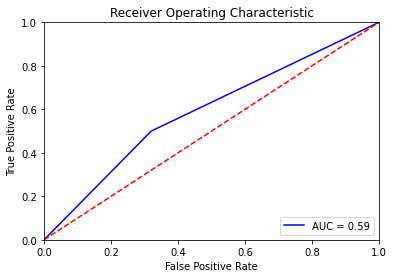

{'max_depth': 4, 'min_samples_leaf': 9}
Mejor ROC-AUC en validación cruzada: 0.626
Mejor valor del hiperparámetro: {'max_depth': 4, 'min_samples_leaf': 9}
0.6938775510204082
[[13 12]
 [ 3 21]]
Sensibilidad, Accuracy, Especifididad, f1-score 0.875 0.6938775510204082 0.52 0.7368421052631579


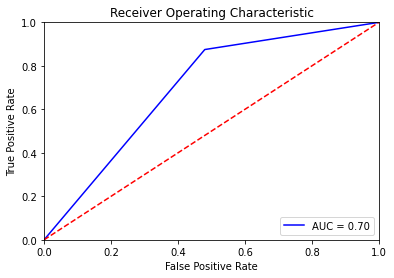

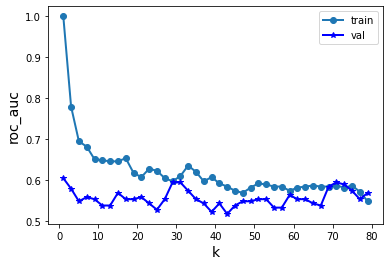

Mayor valor de la figura de mérito en validación con características estandarizadas: 0.605
Valor correspondiente para el hiperparámetro: {'n_neighbors': 1}
0.6122448979591837
[[17  8]
 [11 13]]
Sensibilidad, Accuracy, Especificidad, f1-score 0.5416666666666666 0.6122448979591837 0.68 0.5777777777777778


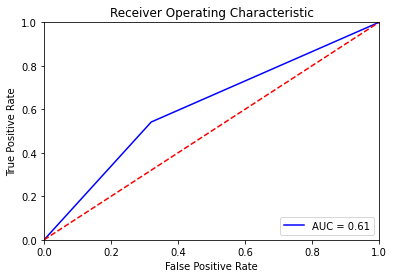

Valor correspondiente para el hiperparámetro: {'C': 50, 'gamma': 0.01, 'kernel': 'rbf'}
Mayor valor de la figura de mérito en validación con características estandarizadas: 0.641
0.5714285714285714
[[14 11]
 [10 14]]
Sensibilidad, Accuracy, Especificidad, f1-score 0.5833333333333334 0.5714285714285714 0.56 0.5714285714285714


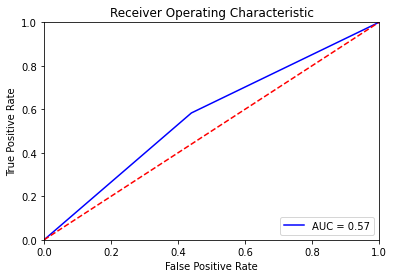

Valor correspondiente para el hiperparámetro: {'C': 10, 'gamma': 0.01, 'kernel': 'linear'}
Mayor valor de la figura de mérito en validación con características estandarizadas: 0.626
0.5714285714285714
[[13 12]
 [ 9 15]]
Sensibilidad, Accuracy, Especificidad, f1-score 0.625 0.5714285714285714 0.52 0.5882352941176471


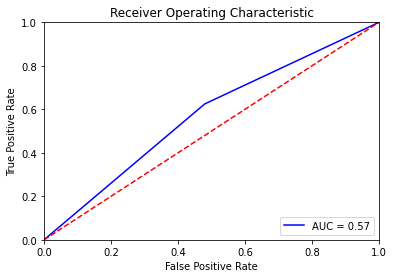

In [ ]:
#VARIABLES NORMALIZADAS CON MIN-MAX

r=regresion_logistica(X_train_scaler_all0,X_test_scaler_all0,Y_train_0,Y_test_0,0)
recall_reg_scaler.append(r[0])
accuracy_reg_scaler.append(r[1])
precision_reg_scaler.append(r[2])
f1_reg_scaler.append(r[3])
roc_reg_scaler.append(r[4])

a=decisionTree(X_train_scaler_all0,X_test_scaler_all0,Y_train_0,Y_test_0,0)
recall_arbol_scaler.append(a[0])
accuracy_arbol_scaler.append(a[1])
precision_arbol_scaler.append(a[2])
f1_arbol_scaler.append(a[3])
roc_arbol_scaler.append(a[4])

k=knn(X_train_scaler_all0,X_test_scaler_all0,Y_train_0,Y_test_0)
recall_knn_scaler.append(k[0])
accuracy_knn_scaler.append(k[1])
precision_knn_scaler.append(k[2])
f1_knn_scaler.append(k[3])
roc_knn_scaler.append(k[4])

s=svc(X_train_scaler_all0,X_test_scaler_all0,Y_train_0,Y_test_0,0)
recall_svc_scaler.append(s[0])
accuracy_svc_scaler.append(s[1])
precision_svc_scaler.append(s[2])
f1_svc_scaler.append(s[3])
roc_svc_scaler.append(s[4])

sl=svc_lineal(X_train_scaler_all0,X_test_scaler_all0,Y_train_0,Y_test_0,0)
recall_svc_lin_scaler.append(sl[0])
accuracy_svc_lin_scaler.append(sl[1])
precision_svc_lin_scaler.append(sl[2])
f1_svc_lin_scaler.append(sl[3])
roc_svc_lin_scaler.append(sl[4])

# ***Segunda partición***

In [69]:
X_train_1=list_x_train[1]
Y_train_1=list_y_train[1]
X_test_1=list_x_test[1]
Y_test_1=list_y_test[1]

In [70]:
X_train_1.isna().sum()

Value_HBA1C    0
Value_CPEP     0
Value_CREAS    5
Value_GLU      5
dtype: int64

Debemos imputar los valores nulos con knn_imputer:

In [71]:

# from numpy import mean
# from numpy import std
# from pandas import read_csv
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.impute import KNNImputer
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.pipeline import Pipeline
# from matplotlib import pyplot

# # evaluate each strategy on the dataset
# results = list()
# strategies = [str(i) for i in [1,3,5,7,9,15,18,21]]
# for s in strategies:
# 	# create the modeling pipeline
# 	pipeline = Pipeline(steps=[('i', KNNImputer(n_neighbors=int(s))), ('m', RandomForestClassifier())])
# 	# evaluate the model
# 	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
# 	scores = cross_val_score(pipeline, X_train_1, Y_train_1, scoring='accuracy', cv=cv, n_jobs=-1)
# 	# store results
# 	results.append(scores)
# 	print('>%s %.3f (%.3f)' % (s, mean(scores), std(scores)))
# # plot model performance for comparison
# pyplot.boxplot(results, labels=strategies, showmeans=True)
# pyplot.show()

In [72]:
from numpy import isnan
from pandas import read_csv
from sklearn.impute import KNNImputer

# define imputer
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

imputer.fit(X_train_1)

# transform the dataset
X_train_1 = imputer.transform(X_train_1)

# print total missing
print('Missing: %d' % sum(isnan(X_train_1).flatten()))

X_test_1=imputer.transform(X_test_1)
print('Missing: %d' % sum(isnan(X_test_1).flatten()))


Missing: 0
Missing: 0


In [73]:

from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing


std_all2 = preprocessing.StandardScaler().fit(X_train_1)
X_train_std_all1 = std_all2.transform(X_train_1) #Tendriamos todas las características estandarizadas
X_test_std_all1= std_all2.transform(X_test_1)

In [74]:
X_train_std_all1.shape

(178, 4)

In [75]:
#CON MIN-MAX

scaler = preprocessing.MinMaxScaler().fit(X_train_1)
X_train_scaler_all1 = scaler.transform(X_train_1) 
X_test_scaler_all1=scaler.transform(X_test_1)

A continuación, aplicacmos los modelos:

In [76]:
#CON VARIABLES NORMALIZADAS CON STANDARD SCALER

# r=regresion_logistica(X_train_std_all1,X_test_std_all1,Y_train_1,Y_test_1,1)
# recall_reg_std.append(r[0])
# accuracy_reg_std.append(r[1])
# precision_reg_std.append(r[2])
# f1_reg_std.append(r[3])
# roc_reg_std.append(r[4])

# a=decisionTree(X_train_std_all1,X_test_std_all1,Y_train_1,Y_test_1,1)
# recall_arbol_std.append(a[0])
# accuracy_arbol_std.append(a[1])
# precision_arbol_std.append(a[2])
# f1_arbol_std.append(a[3])
# roc_arbol_std.append(a[4])

# k=knn(X_train_std_all1,X_test_std_all1,Y_train_1,Y_test_1)
# recall_knn_std.append(k[0])
# accuracy_knn_std.append(k[1])
# precision_knn_std.append(k[2])
# f1_knn_std.append(k[3])
# roc_knn_std.append(k[4])

# s=svc(X_train_std_all1,X_test_std_all1,Y_train_1,Y_test_1,1)
# recall_svc_std.append(s[0])
# accuracy_svc_std.append(s[1])
# precision_svc_std.append(s[2])
# f1_svc_std.append(s[3])
# roc_svc_std.append(s[4])

# sl=svc_lineal(X_train_std_all1,X_test_std_all1,Y_train_1,Y_test_1,1)
# recall_svc_lin_std.append(sl[0])
# accuracy_svc_lin_std.append(sl[1])
# precision_svc_lin_std.append(sl[2])
# f1_svc_lin_std.append(sl[3])
# roc_svc_lin_std.append(sl[4])

Valor correspondiente para el hiperparámetro: {'C': 10, 'penalty': 'l1'}
Mayor valor de la figura de mérito en validación con características estandarizadas: 0.600
0.5510204081632653
[[10 15]
 [ 7 17]]
Sensibilidad, Accuracy, Especificidad, f1-score 0.7083333333333334 0.5510204081632653 0.4 0.6071428571428571


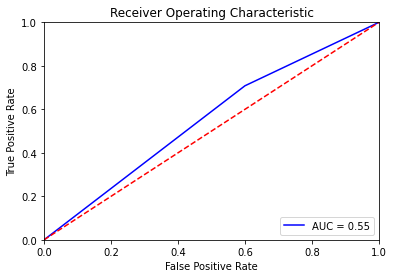

{'max_depth': 4, 'min_samples_leaf': 8}
Mejor ROC-AUC en validación cruzada: 0.595
Mejor valor del hiperparámetro: {'max_depth': 4, 'min_samples_leaf': 8}
0.6326530612244898
[[ 7 18]
 [ 0 24]]
Sensibilidad, Accuracy, Especifididad, f1-score 1.0 0.6326530612244898 0.28 0.7272727272727273


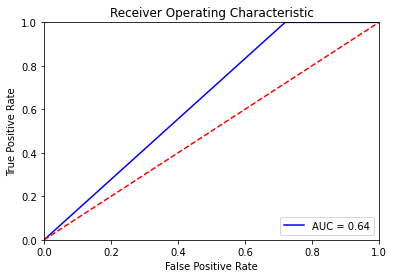

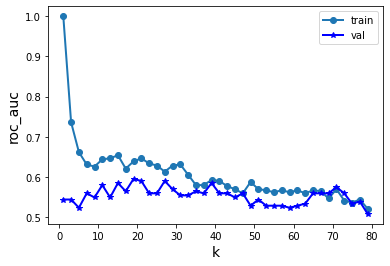

Mayor valor de la figura de mérito en validación con características estandarizadas: 0.595
Valor correspondiente para el hiperparámetro: {'n_neighbors': 19}
0.5306122448979592
[[11 14]
 [ 9 15]]
Sensibilidad, Accuracy, Especificidad, f1-score 0.625 0.5306122448979592 0.44 0.5660377358490567


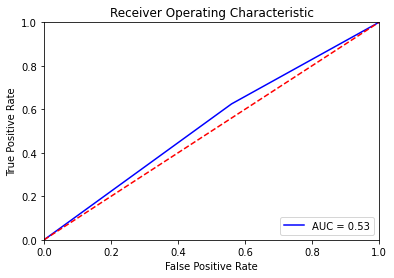

Valor correspondiente para el hiperparámetro: {'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}
Mayor valor de la figura de mérito en validación con características estandarizadas: 0.595
0.5714285714285714
[[ 9 16]
 [ 5 19]]
Sensibilidad, Accuracy, Especificidad, f1-score 0.7916666666666666 0.5714285714285714 0.36 0.6440677966101694


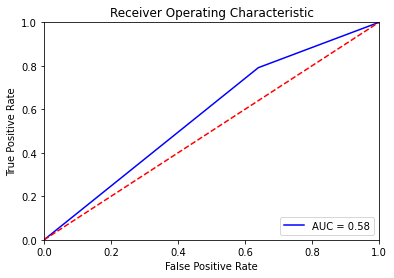

Valor correspondiente para el hiperparámetro: {'C': 1000, 'gamma': 0.01, 'kernel': 'linear'}
Mayor valor de la figura de mérito en validación con características estandarizadas: 0.595
0.6122448979591837
[[10 15]
 [ 4 20]]
Sensibilidad, Accuracy, Especificidad, f1-score 0.8333333333333334 0.6122448979591837 0.4 0.6779661016949152


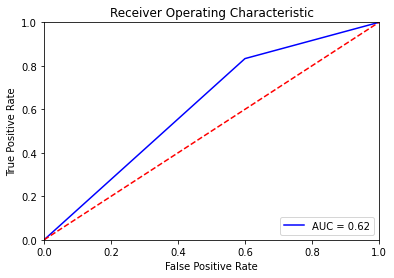

In [ ]:
#VARIABLES NORMALIZADAS CON MIN-MAX

r=regresion_logistica(X_train_scaler_all1,X_test_scaler_all1,Y_train_1,Y_test_1,1)
recall_reg_scaler.append(r[0])
accuracy_reg_scaler.append(r[1])
precision_reg_scaler.append(r[2])
f1_reg_scaler.append(r[3])
roc_reg_scaler.append(r[4])

a=decisionTree(X_train_scaler_all1,X_test_scaler_all1,Y_train_1,Y_test_1,1)
recall_arbol_scaler.append(a[0])
accuracy_arbol_scaler.append(a[1])
precision_arbol_scaler.append(a[2])
f1_arbol_scaler.append(a[3])
roc_arbol_scaler.append(a[4])

k=knn(X_train_scaler_all1,X_test_scaler_all1,Y_train_1,Y_test_1)
recall_knn_scaler.append(k[0])
accuracy_knn_scaler.append(k[1])
precision_knn_scaler.append(k[2])
f1_knn_scaler.append(k[3])
roc_knn_scaler.append(k[4])

s=svc(X_train_scaler_all1,X_test_scaler_all1,Y_train_1,Y_test_1,1)
recall_svc_scaler.append(s[0])
accuracy_svc_scaler.append(s[1])
precision_svc_scaler.append(s[2])
f1_svc_scaler.append(s[3])
roc_svc_scaler.append(s[4])

sl=svc_lineal(X_train_scaler_all1,X_test_scaler_all1,Y_train_1,Y_test_1,1)
recall_svc_lin_scaler.append(sl[0])
accuracy_svc_lin_scaler.append(sl[1])
precision_svc_lin_scaler.append(sl[2])
f1_svc_lin_scaler.append(sl[3])
roc_svc_lin_scaler.append(sl[4])

# ***Tercera partición***

In [77]:
X_train_2=list_x_train[2]
Y_train_2=list_y_train[2]
X_test_2=list_x_test[2]
Y_test_2=list_y_test[2]

In [78]:
X_train_2.isna().sum()

Value_HBA1C    0
Value_CPEP     0
Value_CREAS    6
Value_GLU      6
dtype: int64

Debemos imputar los valores nulos con knn_imputer:

In [79]:

# from numpy import mean
# from numpy import std
# from pandas import read_csv
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.impute import KNNImputer
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.pipeline import Pipeline
# from matplotlib import pyplot

# # evaluate each strategy on the dataset
# results = list()
# strategies = [str(i) for i in [1,3,5,7,9,15,18,21]]
# for s in strategies:
# 	# create the modeling pipeline
# 	pipeline = Pipeline(steps=[('i', KNNImputer(n_neighbors=int(s))), ('m', RandomForestClassifier())])
# 	# evaluate the model
# 	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
# 	scores = cross_val_score(pipeline, X_train_2, Y_train_2, scoring='accuracy', cv=cv, n_jobs=-1)
# 	# store results
# 	results.append(scores)
# 	print('>%s %.3f (%.3f)' % (s, mean(scores), std(scores)))
# # plot model performance for comparison
# pyplot.boxplot(results, labels=strategies, showmeans=True)
# pyplot.show()

In [80]:
from numpy import isnan
from pandas import read_csv
from sklearn.impute import KNNImputer

# define imputer
imputer = KNNImputer(n_neighbors=1, weights='uniform', metric='nan_euclidean')

imputer.fit(X_train_2)

# transform the dataset
X_train_2 = imputer.transform(X_train_2)

# print total missing
print('Missing: %d' % sum(isnan(X_train_2).flatten()))

X_test_2=imputer.transform(X_test_2)
print('Missing: %d' % sum(isnan(X_test_2).flatten()))


Missing: 0
Missing: 0


In [81]:

from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing


std_all2 = preprocessing.StandardScaler().fit(X_train_2)
X_train_std_all2 = std_all2.transform(X_train_2) #Tendriamos todas las características estandarizadas
X_test_std_all2 = std_all2.transform(X_test_2)

In [82]:
X_train_std_all2.shape

(178, 4)

In [83]:
#CON MIN-MAX

scaler = preprocessing.MinMaxScaler().fit(X_train_2)
X_train_scaler_all2 = scaler.transform(X_train_2) 
X_test_scaler_all2=scaler.transform(X_test_2)

A continuación, aplicacmos los modelos:

In [84]:
#CON VARIABLES NORMALIZADAS CON STANDARD SCALER

# r=regresion_logistica(X_train_std_all2,X_test_std_all2,Y_train_2,Y_test_2,5)
# recall_reg_std.append(r[0])
# accuracy_reg_std.append(r[1])
# precision_reg_std.append(r[2])
# f1_reg_std.append(r[3])
# roc_reg_std.append(r[4])

# a=decisionTree(X_train_std_all2,X_test_std_all2,Y_train_2,Y_test_2,5)
# recall_arbol_std.append(a[0])
# accuracy_arbol_std.append(a[1])
# precision_arbol_std.append(a[2])
# f1_arbol_std.append(a[3])
# roc_arbol_std.append(a[4])

# k=knn(X_train_std_all2,X_test_std_all2,Y_train_2,Y_test_2)
# recall_knn_std.append(k[0])
# accuracy_knn_std.append(k[1])
# precision_knn_std.append(k[2])
# f1_knn_std.append(k[3])
# roc_knn_std.append(k[4])

# s=svc(X_train_std_all2,X_test_std_all2,Y_train_2,Y_test_2,5)
# recall_svc_std.append(s[0])
# accuracy_svc_std.append(s[1])
# precision_svc_std.append(s[2])
# f1_svc_std.append(s[3])
# roc_svc_std.append(s[4])

# sl=svc_lineal(X_train_std_all2,X_test_std_all2,Y_train_2,Y_test_2,5)
# recall_svc_lin_std.append(sl[0])
# accuracy_svc_lin_std.append(sl[1])
# precision_svc_lin_std.append(sl[2])
# f1_svc_lin_std.append(sl[3])
# roc_svc_lin_std.append(s[4])


Valor correspondiente para el hiperparámetro: {'C': 10, 'penalty': 'l1'}
Mayor valor de la figura de mérito en validación con características estandarizadas: 0.646
0.5102040816326531
[[11 13]
 [11 14]]
Sensibilidad, Accuracy, Especificidad, f1-score 0.56 0.5102040816326531 0.4583333333333333 0.5384615384615384


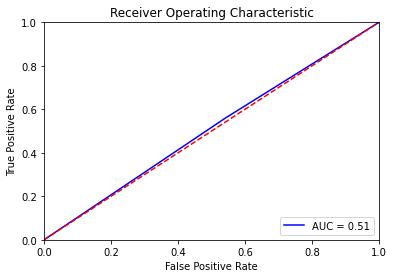

{'max_depth': 1, 'min_samples_leaf': 39}
Mejor ROC-AUC en validación cruzada: 0.631
Mejor valor del hiperparámetro: {'max_depth': 1, 'min_samples_leaf': 39}
0.5102040816326531
[[10 14]
 [10 15]]
Sensibilidad, Accuracy, Especifididad, f1-score 0.6 0.5102040816326531 0.4166666666666667 0.5555555555555556


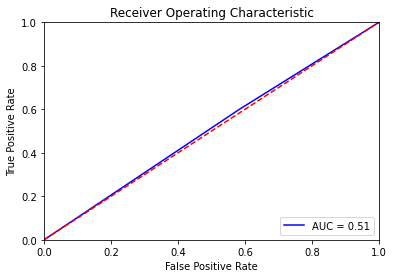

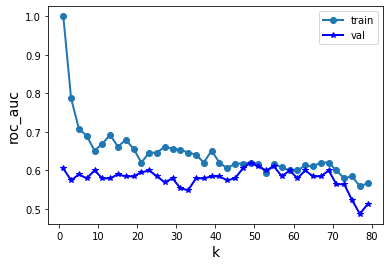

Mayor valor de la figura de mérito en validación con características estandarizadas: 0.621
Valor correspondiente para el hiperparámetro: {'n_neighbors': 49}
0.4897959183673469
[[10 14]
 [11 14]]
Sensibilidad, Accuracy, Especificidad, f1-score 0.56 0.4897959183673469 0.4166666666666667 0.5283018867924528


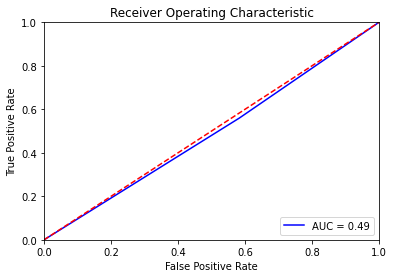

Valor correspondiente para el hiperparámetro: {'C': 50, 'gamma': 0.01, 'kernel': 'rbf'}
Mayor valor de la figura de mérito en validación con características estandarizadas: 0.636
0.5306122448979592
[[10 14]
 [ 9 16]]
Sensibilidad, Accuracy, Especificidad, f1-score 0.64 0.5306122448979592 0.4166666666666667 0.5818181818181818


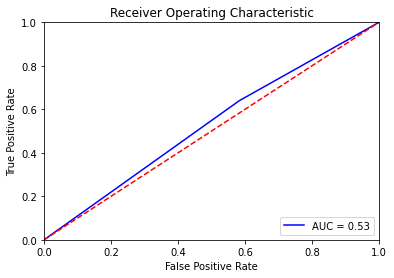

Valor correspondiente para el hiperparámetro: {'C': 25, 'gamma': 0.01, 'kernel': 'linear'}
Mayor valor de la figura de mérito en validación con características estandarizadas: 0.631
0.5102040816326531
[[ 9 15]
 [ 9 16]]
Sensibilidad, Accuracy, Especificidad, f1-score 0.64 0.5102040816326531 0.375 0.5714285714285714


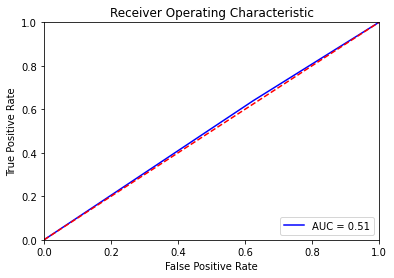

In [ ]:
#VARIABLES NORMALIZADAS CON MIN-MAX

r=regresion_logistica(X_train_scaler_all2,X_test_scaler_all2,Y_train_2,Y_test_2,2)
recall_reg_scaler.append(r[0])
accuracy_reg_scaler.append(r[1])
precision_reg_scaler.append(r[2])
f1_reg_scaler.append(r[3])
roc_reg_scaler.append(r[4])

a=decisionTree(X_train_scaler_all2,X_test_scaler_all2,Y_train_2,Y_test_2,2)
recall_arbol_scaler.append(a[0])
accuracy_arbol_scaler.append(a[1])
precision_arbol_scaler.append(a[2])
f1_arbol_scaler.append(a[3])
roc_arbol_scaler.append(a[4])

k=knn(X_train_scaler_all2,X_test_scaler_all2,Y_train_2,Y_test_2)
recall_knn_scaler.append(k[0])
accuracy_knn_scaler.append(k[1])
precision_knn_scaler.append(k[2])
f1_knn_scaler.append(k[3])
roc_knn_scaler.append(k[4])

s=svc(X_train_scaler_all2,X_test_scaler_all2,Y_train_2,Y_test_2,2)
recall_svc_scaler.append(s[0])
accuracy_svc_scaler.append(s[1])
precision_svc_scaler.append(s[2])
f1_svc_scaler.append(s[3])
roc_svc_scaler.append(s[4])

sl=svc_lineal(X_train_scaler_all2,X_test_scaler_all2,Y_train_2,Y_test_2,2)
recall_svc_lin_scaler.append(sl[0])
accuracy_svc_lin_scaler.append(sl[1])
precision_svc_lin_scaler.append(sl[2])
f1_svc_lin_scaler.append(sl[3])
roc_svc_lin_scaler.append(sl[4])

# ***Cuarta partición***

In [85]:
X_train_3=list_x_train[3]
Y_train_3=list_y_train[3]
X_test_3=list_x_test[3]
Y_test_3=list_y_test[3]

In [86]:
X_train_3.isna().sum()

Value_HBA1C    0
Value_CPEP     0
Value_CREAS    6
Value_GLU      5
dtype: int64

Debemos imputar los valores nulos con knn_imputer:

In [87]:

# from numpy import mean
# from numpy import std
# from pandas import read_csv
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.impute import KNNImputer
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.pipeline import Pipeline
# from matplotlib import pyplot

# # evaluate each strategy on the dataset
# results = list()
# strategies = [str(i) for i in [1,3,5,7,9,15,18,21]]
# for s in strategies:
# 	# create the modeling pipeline
# 	pipeline = Pipeline(steps=[('i', KNNImputer(n_neighbors=int(s))), ('m', RandomForestClassifier())])
# 	# evaluate the model
# 	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
# 	scores = cross_val_score(pipeline, X_train_3, Y_train_3, scoring='accuracy', cv=cv, n_jobs=-1)
# 	# store results
# 	results.append(scores)
# 	print('>%s %.3f (%.3f)' % (s, mean(scores), std(scores)))
# # plot model performance for comparison
# pyplot.boxplot(results, labels=strategies, showmeans=True)
# pyplot.show()

In [88]:
from numpy import isnan
from pandas import read_csv
from sklearn.impute import KNNImputer

# define imputer
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

imputer.fit(X_train_3)

# transform the dataset
X_train_3 = imputer.transform(X_train_3)

# print total missing
print('Missing: %d' % sum(isnan(X_train_3).flatten()))

X_test_3=imputer.transform(X_test_3)
print('Missing: %d' % sum(isnan(X_test_3).flatten()))


Missing: 0
Missing: 0


In [89]:

std_all2 = preprocessing.StandardScaler().fit(X_train_3)
X_train_std_all3 = std_all2.transform(X_train_3) #Tendriamos todas las características estandarizadas
X_test_std_all3 = std_all2.transform(X_test_3)

In [90]:
X_train_std_all3.shape

(178, 4)

In [91]:
#CON MIN-MAX

scaler = preprocessing.MinMaxScaler().fit(X_train_3)
X_train_scaler_all3 = scaler.transform(X_train_3) 
X_test_scaler_all3=scaler.transform(X_test_3)

A continuación, aplicacmos los modelos:

In [92]:
#CON VARIABLES NORMALIZADAS CON STANDARD SCALER

# r=regresion_logistica(X_train_std_all3,X_test_std_all3,Y_train_3,Y_test_3,3)
# recall_reg_std.append(r[0])
# accuracy_reg_std.append(r[1])
# precision_reg_std.append(r[2])
# f1_reg_std.append(r[3])
# roc_reg_std.append(r[4])

# a=decisionTree(X_train_std_all3,X_test_std_all3,Y_train_3,Y_test_3,3)
# recall_arbol_std.append(a[0])
# accuracy_arbol_std.append(a[1])
# precision_arbol_std.append(a[2])
# f1_arbol_std.append(a[3])
# roc_arbol_std.append(a[4])

# k=knn(X_train_std_all3,X_test_std_all3,Y_train_3,Y_test_3)
# recall_knn_std.append(k[0])
# accuracy_knn_std.append(k[1])
# precision_knn_std.append(k[2])
# f1_knn_std.append(k[3])
# roc_knn_std.append(k[4])

# s=svc(X_train_std_all3,X_test_std_all3,Y_train_3,Y_test_3,3)
# recall_svc_std.append(s[0])
# accuracy_svc_std.append(s[1])
# precision_svc_std.append(s[2])
# f1_svc_std.append(s[3])
# roc_svc_std.append(s[4])

# sl=svc_lineal(X_train_std_all3,X_test_std_all3,Y_train_3,Y_test_3,3)
# recall_svc_lin_std.append(sl[0])
# accuracy_svc_lin_std.append(sl[1])
# precision_svc_lin_std.append(sl[2])
# f1_svc_lin_std.append(sl[3])
# roc_svc_lin_std.append(s[4])


Valor correspondiente para el hiperparámetro: {'C': 50, 'penalty': 'l1'}
Mayor valor de la figura de mérito en validación con características estandarizadas: 0.641
0.5714285714285714
[[16  9]
 [12 12]]
Sensibilidad, Accuracy, Especificidad, f1-score 0.5 0.5714285714285714 0.64 0.5333333333333333


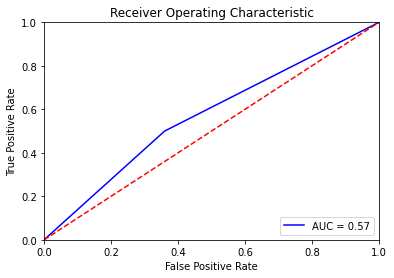

{'max_depth': 3, 'min_samples_leaf': 5}
Mejor ROC-AUC en validación cruzada: 0.636
Mejor valor del hiperparámetro: {'max_depth': 3, 'min_samples_leaf': 5}
0.6326530612244898
[[ 8 17]
 [ 1 23]]
Sensibilidad, Accuracy, Especifididad, f1-score 0.9583333333333334 0.6326530612244898 0.32 0.71875


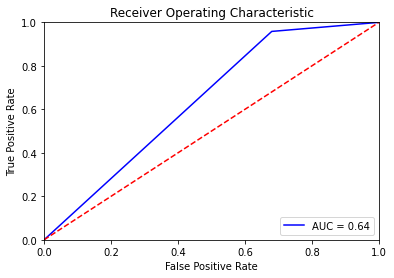

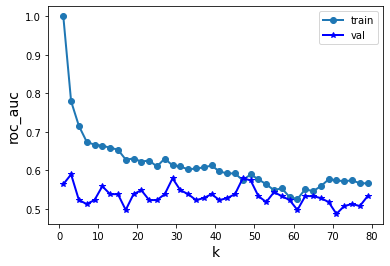

Mayor valor de la figura de mérito en validación con características estandarizadas: 0.590
Valor correspondiente para el hiperparámetro: {'n_neighbors': 3}
0.5510204081632653
[[16  9]
 [13 11]]
Sensibilidad, Accuracy, Especificidad, f1-score 0.4583333333333333 0.5510204081632653 0.64 0.5


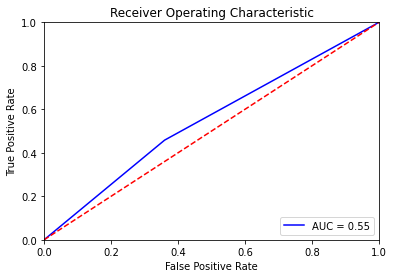

Valor correspondiente para el hiperparámetro: {'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}
Mayor valor de la figura de mérito en validación con características estandarizadas: 0.615
0.5510204081632653
[[15 10]
 [12 12]]
Sensibilidad, Accuracy, Especificidad, f1-score 0.5 0.5510204081632653 0.6 0.5217391304347826


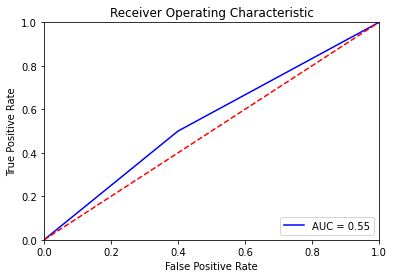

Valor correspondiente para el hiperparámetro: {'C': 10, 'gamma': 0.01, 'kernel': 'linear'}
Mayor valor de la figura de mérito en validación con características estandarizadas: 0.610
0.5714285714285714
[[15 10]
 [11 13]]
Sensibilidad, Accuracy, Especificidad, f1-score 0.5416666666666666 0.5714285714285714 0.6 0.5531914893617021


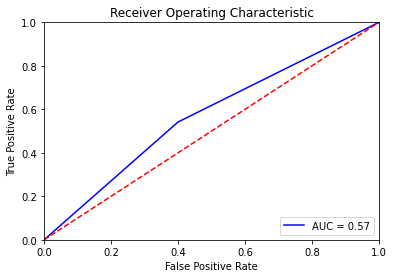

In [ ]:
#VARIABLES NORMALIZADAS CON MIN-MAX

r=regresion_logistica(X_train_scaler_all3,X_test_scaler_all3,Y_train_3,Y_test_3,3)
recall_reg_scaler.append(r[0])
accuracy_reg_scaler.append(r[1])
precision_reg_scaler.append(r[2])
f1_reg_scaler.append(r[3])
roc_reg_scaler.append(r[4])

a=decisionTree(X_train_scaler_all3,X_test_scaler_all3,Y_train_3,Y_test_3,3)
recall_arbol_scaler.append(a[0])
accuracy_arbol_scaler.append(a[1])
precision_arbol_scaler.append(a[2])
f1_arbol_scaler.append(a[3])
roc_arbol_scaler.append(a[4])

k=knn(X_train_scaler_all3,X_test_scaler_all3,Y_train_3,Y_test_3)
recall_knn_scaler.append(k[0])
accuracy_knn_scaler.append(k[1])
precision_knn_scaler.append(k[2])
f1_knn_scaler.append(k[3])
roc_knn_scaler.append(k[4])

s=svc(X_train_scaler_all3,X_test_scaler_all3,Y_train_3,Y_test_3,3)
recall_svc_scaler.append(s[0])
accuracy_svc_scaler.append(s[1])
precision_svc_scaler.append(s[2])
f1_svc_scaler.append(s[3])
roc_svc_scaler.append(s[4])

sl=svc_lineal(X_train_scaler_all3,X_test_scaler_all3,Y_train_3,Y_test_3,3)
recall_svc_lin_scaler.append(sl[0])
accuracy_svc_lin_scaler.append(sl[1])
precision_svc_lin_scaler.append(sl[2])
f1_svc_lin_scaler.append(sl[3])
roc_svc_lin_scaler.append(sl[4])

# ***Quinta partición***

In [93]:
X_train_4=list_x_train[4]
Y_train_4=list_y_train[4]
X_test_4=list_x_test[4]
Y_test_4=list_y_test[4]

In [94]:
X_train_4.isna().sum()

Value_HBA1C    0
Value_CPEP     0
Value_CREAS    4
Value_GLU      3
dtype: int64

Debemos imputar los valores nulos con knn_imputer:

In [95]:

# from numpy import mean
# from numpy import std
# from pandas import read_csv
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.impute import KNNImputer
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.pipeline import Pipeline
# from matplotlib import pyplot

# # evaluate each strategy on the dataset
# results = list()
# strategies = [str(i) for i in [1,3,5,7,9,15,18,21]]
# for s in strategies:
# 	# create the modeling pipeline
# 	pipeline = Pipeline(steps=[('i', KNNImputer(n_neighbors=int(s))), ('m', RandomForestClassifier())])
# 	# evaluate the model
# 	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
# 	scores = cross_val_score(pipeline, X_train_4, Y_train_4, scoring='accuracy', cv=cv, n_jobs=-1)
# 	# store results
# 	results.append(scores)
# 	print('>%s %.3f (%.3f)' % (s, mean(scores), std(scores)))
# # plot model performance for comparison
# pyplot.boxplot(results, labels=strategies, showmeans=True)
# pyplot.show()

In [96]:
from numpy import isnan
from pandas import read_csv
from sklearn.impute import KNNImputer

# define imputer
imputer = KNNImputer(n_neighbors=9, weights='uniform', metric='nan_euclidean')

imputer.fit(X_train_4)

# transform the dataset
X_train_4 = imputer.transform(X_train_4)

# print total missing
print('Missing: %d' % sum(isnan(X_train_4).flatten()))

X_test_4=imputer.transform(X_test_4)
print('Missing: %d' % sum(isnan(X_test_4).flatten()))


Missing: 0
Missing: 0


In [97]:

std_all2 = preprocessing.StandardScaler().fit(X_train_4)
X_train_std_all4 = std_all2.transform(X_train_4) #Tendriamos todas las características estandarizadas
X_test_std_all4 = std_all2.transform(X_test_4)

In [98]:
X_train_std_all4.shape

(178, 4)

In [99]:
#CON MIN-MAX

scaler = preprocessing.MinMaxScaler().fit(X_train_4)
X_train_scaler_all4 = scaler.transform(X_train_4) 
X_test_scaler_all4=scaler.transform(X_test_4)

A continuación, aplicacmos los modelos:

In [100]:
# #CON VARIABLES NORMALIZADAS CON STANDARD SCALER

# r=regresion_logistica(X_train_std_all4,X_test_std_all4,Y_train_4,Y_test_4,4)
# recall_reg_std.append(r[0])
# accuracy_reg_std.append(r[1])
# precision_reg_std.append(r[2])
# f1_reg_std.append(r[3])
# roc_reg_std.append(r[4])

# a=decisionTree(X_train_std_all4,X_test_std_all4,Y_train_4,Y_test_4,4)
# recall_arbol_std.append(a[0])
# accuracy_arbol_std.append(a[1])
# precision_arbol_std.append(a[2])
# f1_arbol_std.append(a[3])
# roc_arbol_std.append(a[4])

# k=knn(X_train_std_all4,X_test_std_all4,Y_train_4,Y_test_4)
# recall_knn_std.append(k[0])
# accuracy_knn_std.append(k[1])
# precision_knn_std.append(k[2])
# f1_knn_std.append(k[3])
# roc_knn_std.append(k[4])

# s=svc(X_train_std_all4,X_test_std_all4,Y_train_4,Y_test_4,4)
# recall_svc_std.append(s[0])
# accuracy_svc_std.append(s[1])
# precision_svc_std.append(s[2])
# f1_svc_std.append(s[3])
# roc_svc_std.append(s[4])

# sl=svc_lineal(X_train_std_all4,X_test_std_all4,Y_train_4,Y_test_4,4)
# recall_svc_lin_std.append(sl[0])
# accuracy_svc_lin_std.append(sl[1])
# precision_svc_lin_std.append(sl[2])
# f1_svc_lin_std.append(sl[3])
# roc_svc_lin_std.append(sl[4])

Valor correspondiente para el hiperparámetro: {'C': 20, 'penalty': 'l1'}
Mayor valor de la figura de mérito en validación con características estandarizadas: 0.600
0.5918367346938775
[[11 13]
 [ 7 18]]
Sensibilidad, Accuracy, Especificidad, f1-score 0.72 0.5918367346938775 0.4583333333333333 0.6428571428571428


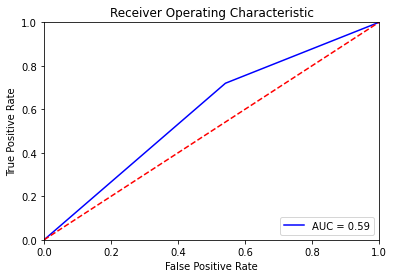

{'max_depth': 2, 'min_samples_leaf': 5}
Mejor ROC-AUC en validación cruzada: 0.667
Mejor valor del hiperparámetro: {'max_depth': 2, 'min_samples_leaf': 5}
0.5918367346938775
[[ 6 18]
 [ 2 23]]
Sensibilidad, Accuracy, Especifididad, f1-score 0.92 0.5918367346938775 0.25 0.6969696969696971


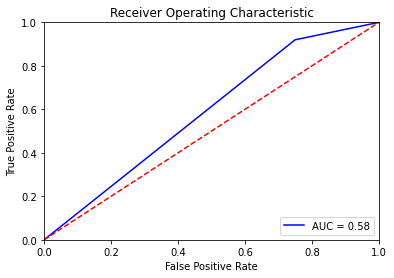

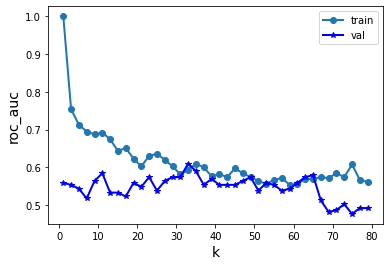

Mayor valor de la figura de mérito en validación con características estandarizadas: 0.610
Valor correspondiente para el hiperparámetro: {'n_neighbors': 33}
0.5102040816326531
[[ 9 15]
 [ 9 16]]
Sensibilidad, Accuracy, Especificidad, f1-score 0.64 0.5102040816326531 0.375 0.5714285714285714


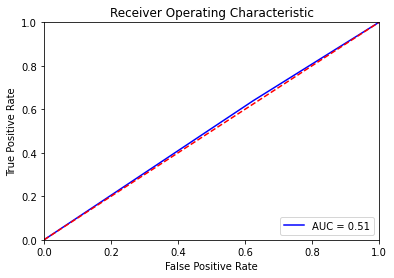

Valor correspondiente para el hiperparámetro: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Mayor valor de la figura de mérito en validación con características estandarizadas: 0.590
0.5714285714285714
[[10 14]
 [ 7 18]]
Sensibilidad, Accuracy, Especificidad, f1-score 0.72 0.5714285714285714 0.4166666666666667 0.631578947368421


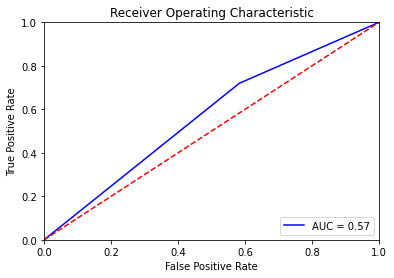

Valor correspondiente para el hiperparámetro: {'C': 10, 'gamma': 0.01, 'kernel': 'linear'}
Mayor valor de la figura de mérito en validación con características estandarizadas: 0.595
0.5714285714285714
[[10 14]
 [ 7 18]]
Sensibilidad, Accuracy, Especificidad, f1-score 0.72 0.5714285714285714 0.4166666666666667 0.631578947368421


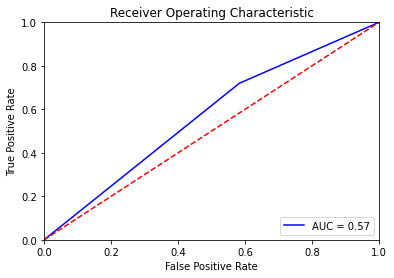

In [ ]:
#VARIABLES NORMALIZADAS CON MIN-MAX

r=regresion_logistica(X_train_scaler_all4,X_test_scaler_all4,Y_train_4,Y_test_4,4)
recall_reg_scaler.append(r[0])
accuracy_reg_scaler.append(r[1])
precision_reg_scaler.append(r[2])
f1_reg_scaler.append(r[3])
roc_reg_scaler.append(r[4])

a=decisionTree(X_train_scaler_all4,X_test_scaler_all4,Y_train_4,Y_test_4,4)
recall_arbol_scaler.append(a[0])
accuracy_arbol_scaler.append(a[1])
precision_arbol_scaler.append(a[2])
f1_arbol_scaler.append(a[3])
roc_arbol_scaler.append(a[4])

k=knn(X_train_scaler_all4,X_test_scaler_all4,Y_train_4,Y_test_4)
recall_knn_scaler.append(k[0])
accuracy_knn_scaler.append(k[1])
precision_knn_scaler.append(k[2])
f1_knn_scaler.append(k[3])
roc_knn_scaler.append(k[4])

s=svc(X_train_scaler_all4,X_test_scaler_all4,Y_train_4,Y_test_4,4)
recall_svc_scaler.append(s[0])
accuracy_svc_scaler.append(s[1])
precision_svc_scaler.append(s[2])
f1_svc_scaler.append(s[3])
roc_svc_scaler.append(s[4])

sl=svc_lineal(X_train_scaler_all4,X_test_scaler_all4,Y_train_4,Y_test_4,4)
recall_svc_lin_scaler.append(sl[0])
accuracy_svc_lin_scaler.append(sl[1])
precision_svc_lin_scaler.append(sl[2])
f1_svc_lin_scaler.append(sl[3])
roc_svc_lin_scaler.append(sl[4])


In [ ]:
def plot_mean_std_metric(df_metrics, lims, metric_name='accuracy', title_figure='mean_std_plot', flag_save_figure=False):

    fig, ax = plt.subplots(1, 1, figsize=(6.5, 4.5))

    ax.plot(df_metrics['mean'], df_metrics['model'], ls='', marker='o', color='#8000FF')

    ax.hlines(df_metrics['model'], df_metrics['mean'] - df_metrics['std'], df_metrics['mean'] + df_metrics['std'],
              label='', lw=2, color='#8000FF', ls='-')

    ax.grid(axis='x', ls='-')
    ax.grid(axis='y', ls=':', lw=1, alpha=0.5)
    ax.set(
        xlabel=metric_name,
        xlim=lims,
        title=title_figure
    )

    fig.tight_layout()

    if flag_save_figure:
        fig.savefig(title_figure, dpi=300, bbox_inches='tight')
    else:
        plt.show()

In [ ]:

model_scaler=['LASSO', 'DT', 'KNN','Radial SVM', 'Linear SVM']
mean_scaler=[np.mean(accuracy_reg_scaler), np.mean(accuracy_arbol_scaler),np.mean(accuracy_knn_scaler),np.mean(accuracy_svc_scaler),np.mean(accuracy_svc_lin_scaler)]
std_scaler=[np.std(accuracy_reg_scaler), np.std(accuracy_arbol_scaler),np.std(accuracy_knn_scaler),np.std(accuracy_svc_scaler),np.std(accuracy_svc_lin_scaler)]

df_acc_scaler= pd.DataFrame()
df_acc_scaler['model'] = None
df_acc_scaler['mean'] = None
df_acc_scaler['std'] = None


df_acc_scaler['model'] = model_scaler
df_acc_scaler['mean'] = mean_scaler
df_acc_scaler['std'] = std_scaler


In [ ]:
df_acc_scaler

,model,mean,std
0,LASSO,0.563265,0.030544
1,DT,0.612245,0.060540
2,KNN,0.538776,0.042023
3,Radial SVM,0.559184,0.016327
4,Linear SVM,0.567347,0.032653


In [ ]:
model2_scaler=['LASSO', 'DT', 'KNN','Radial SVM', 'Linear SVM']
mean2_scaler=[np.mean(roc_reg_scaler), np.mean(roc_arbol_scaler),np.mean(roc_knn_scaler),np.mean(roc_svc_scaler),np.mean(roc_svc_lin_scaler)]
std2_scaler=[np.std(roc_reg_scaler), np.std(roc_arbol_scaler),np.std(roc_knn_scaler),np.std(roc_svc_scaler),np.std(roc_svc_lin_scaler)]

df_roc_scaler= pd.DataFrame()
df_roc_scaler['model'] = None
df_roc_scaler['mean'] = None
df_roc_scaler['std'] = None


df_roc_scaler['model'] = model2_scaler
df_roc_scaler['mean'] = mean2_scaler
df_roc_scaler['std'] = std2_scaler


In [ ]:
df_roc_scaler

,model,mean,std
0,LASSO,0.562500,0.029791
1,DT,0.614000,0.063699
2,KNN,0.537667,0.042086
3,Radial SVM,0.558833,0.017619
4,Linear SVM,0.567167,0.034795


In [ ]:
#PINTAMOS GRÁFICAS PARA VARIABLES NORMALIZADAS CON STANDARD SCALER PARA ACCURACY Y ROC

plot_mean_std_metric(df_acc_scaler, lims=(0, 0.9), metric_name='',title_figure='', flag_save_figure=True)
# plt.rcParams["figure.figsize"] = (4, 3)
plt.savefig("{}.pdf".format("SampleResults_acc"))
plt.close()

# plot_mean_std_metric(df_roc_scaler, lims=(0, 0.9), metric_name='',title_figure='', flag_save_figure=True)
# # plt.rcParams["figure.figsize"] = (4, 3)
# plt.savefig("{}.pdf".format("Att_auc"))
# plt.close()

In [ ]:
#RECALL
model_scaler3=['LASSO', 'DT', 'KNN','Radial SVM', 'Linear SVM']
mean_scaler3=[np.mean(recall_reg_scaler), np.mean(recall_arbol_scaler),np.mean(recall_knn_scaler),np.mean(recall_svc_scaler),np.mean(recall_svc_lin_scaler)]
std_scaler3=[np.std(recall_reg_scaler), np.std(recall_arbol_scaler),np.std(recall_knn_scaler),np.std(recall_svc_scaler),np.std(recall_svc_lin_scaler)]

df_recall_scaler= pd.DataFrame()
df_recall_scaler['model'] = None
df_recall_scaler['mean'] = None
df_recall_scaler['std'] = None


df_recall_scaler['model'] = model_scaler3
df_recall_scaler['mean'] = mean_scaler3
df_recall_scaler['std'] = std_scaler3

In [ ]:
df_recall_scaler

,model,mean,std
0,LASSO,0.597667,0.097682
1,DT,0.870667,0.141510
2,KNN,0.565000,0.065073
3,Radial SVM,0.647000,0.101950
4,Linear SVM,0.672000,0.098542


In [ ]:
model_scaler4=['LASSO', 'DT', 'KNN','Radial SVM', 'Linear SVM']
mean_scaler4=[np.mean(precision_reg_scaler), np.mean(precision_arbol_scaler),np.mean(precision_knn_scaler),np.mean(precision_svc_scaler),np.mean(precision_svc_lin_scaler)]
std_scaler4=[np.std(precision_reg_scaler), np.std(precision_arbol_scaler),np.std(precision_knn_scaler),np.std(precision_svc_scaler),np.std(precision_svc_lin_scaler)]

df_especificidad_scaler= pd.DataFrame()
df_especificidad_scaler['model'] = None
df_especificidad_scaler['mean'] = None
df_especificidad_scaler['std'] = None


df_especificidad_scaler['model'] = model_scaler4
df_especificidad_scaler['mean'] = mean_scaler4
df_especificidad_scaler['std'] = std_scaler4

In [ ]:
df_especificidad_scaler


,model,mean,std
0,LASSO,0.527333,0.111119
1,DT,0.357333,0.098869
2,KNN,0.510333,0.124608
3,Radial SVM,0.470667,0.092506
4,Linear SVM,0.462333,0.084706


# ***A PARTIR DE AQUÍ: PRUEBAS VARIAS***

# ***División en train y test***

In [101]:
# Creamos x (input) e y (output)
# data.drop(['BCaseControlStatus'], axis=1, inplace=True)
X = data_final.loc[:, data_final.columns != 'BCaseControlStatus']
Y = data_final["BCaseControlStatus"]


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=0)

>1 0.587 (0.105)
>3 0.580 (0.120)
>5 0.602 (0.124)
>7 0.601 (0.122)
>9 0.586 (0.117)
>15 0.584 (0.123)
>18 0.605 (0.122)
>21 0.597 (0.108)


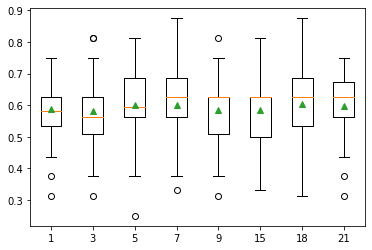

In [ ]:

from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from matplotlib import pyplot

# evaluate each strategy on the dataset
results = list()
strategies = [str(i) for i in [1,3,5,7,9,15,18,21]]
for s in strategies:
	# create the modeling pipeline
	pipeline = Pipeline(steps=[('i', KNNImputer(n_neighbors=int(s))), ('m', RandomForestClassifier())])
	# evaluate the model
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
	scores = cross_val_score(pipeline, X_train, Y_train, scoring='accuracy', cv=cv, n_jobs=-1)
	# store results
	results.append(scores)
	print('>%s %.3f (%.3f)' % (s, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=strategies, showmeans=True)
pyplot.show()

In [ ]:
from numpy import isnan
from pandas import read_csv
from sklearn.impute import KNNImputer

# define imputer
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

imputer.fit(X_train)

# transform the dataset
X_train = imputer.transform(X_train)

# print total missing
print('Missing: %d' % sum(isnan(X_train).flatten()))


Missing: 0


In [ ]:
X_test=imputer.transform(X_test)


In [ ]:
print('Missing: %d' % sum(isnan(X_test).flatten()))


Missing: 0


In [ ]:

from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing


std_all2 = preprocessing.StandardScaler().fit(X_train)
X_std_train2 = std_all2.transform(X_train) #Tendriamos todas las características estandarizadas
X_std_test2 = std_all2.transform(X_test)

In [ ]:

# Regresión logística con regularización 
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection   
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV

logreg= LogisticRegression(solver='liblinear')
parameters = {"C":[1e-8,1e-4,10,100],"penalty":["l1","l2"]}# l1 lasso l2 ridge
valor_C=np.array([1e-8,1e-4,10,100])
log_regression=GridSearchCV(logreg, parameters, scoring='roc_auc', cv=5, return_train_score=True)

log_regression.fit(X_std_train2, Y_train) #Entrenamos

# #Evaluamos las prestaciones para el conjunto de entrenamiento, de validación y representamos
roc_log_train = np.array(log_regression.cv_results_['mean_train_score']) 
roc_loc_val = np.array(log_regression.cv_results_['mean_test_score'])

# #Pintamos la evolución de nuestro modelo tanto en train como en validación para ver cuál es el mejor hiperparámetro para generalizar
# plt.plot(valor_C,roc_log_train,'-o',label="train", linewidth=2)
# plt.plot(valor_C,roc_loc_val,'-*b',label="val", linewidth=2)
# plt.xlabel('C',fontsize=14)
# plt.ylabel('Roc_auc',fontsize=14)
# plt.legend()
# plt.show()

# Mostramos el mejor valor del parámetro y el score
print("Valor correspondiente para el hiperparámetro: {}".format(log_regression.best_params_))
print("Mayor valor de la figura de mérito en validación con características estandarizadas: {:.3f}".format(log_regression.best_score_))






Valor correspondiente para el hiperparámetro: {'C': 100, 'penalty': 'l2'}
Mayor valor de la figura de mérito en validación con características estandarizadas: 0.554


A continuación, ya construimos nuestro modelo con los parámetros obtenidos a partir de validación cruzada y es con un valor de alpha de 0.0001 y un modelo ridge. Así obtenemos los resultados obtenidos en el conjunto de test:

In [ ]:
from sklearn.linear_model import Lasso

logridge=LogisticRegression(solver='liblinear', penalty='l2', C=100)
modelo_rid_log=logridge.fit(X_std_train2, Y_train)

# Obtenemos la salida predicha
y_pred_ridlog = modelo_rid_log.predict(X_std_test2)




A continuación, vamos a calcular diferentes figuras de mérito para ver que resultados obtenemos en test. Comenzamos con la matriz de confusión:

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score

#  Calculamos la matriz de confusión
cm = confusion_matrix(Y_test, y_pred_ridlog)
print(cm)


tn, fp, fn, tp = confusion_matrix(Y_test, y_pred_ridlog).ravel()
print(f'tn: {tn}, fp:{fp}, fn:{fn}, tp:{tp}')

# Calcumos accuracy_score
Accuracy=accuracy_score(Y_test, y_pred_ridlog)
print(f'Accuracy: {Accuracy}')

target_names = ['Paciente control', 'Paciente caso']
print(classification_report(Y_test, y_pred_ridlog, target_names=target_names))
              
#Sensibilidad
Sensibilidad_3 = recall_score(Y_test, y_pred_ridlog)
# S_results.append(Sensibilidad_3)
print(f'Sensibilidad: {Sensibilidad_3}')

[[10  5]
 [ 9 16]]
tn: 10, fp:5, fn:9, tp:16
Accuracy: 0.65
                  precision    recall  f1-score   support

Paciente control       0.53      0.67      0.59        15
   Paciente caso       0.76      0.64      0.70        25

        accuracy                           0.65        40
       macro avg       0.64      0.65      0.64        40
    weighted avg       0.67      0.65      0.66        40

Sensibilidad: 0.64


Calculamos la ROC y la AUC:

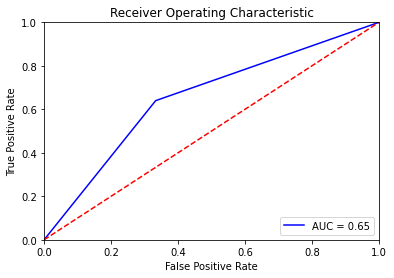

In [ ]:
fpr, tpr, threshold = metrics.roc_curve(Y_test, y_pred_ridlog)
roc_auc_1 = metrics.auc(fpr, tpr)
# AUC_results.append(roc_auc_1)

# Plot the ROC curve
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
res_accuracy=[]
res_recall=[]
res_f1=[]
res_roc=[]

In [ ]:

A1_score = accuracy_score(Y_test, y_pred_ridlog)
f11_score = f1_score(Y_test, y_pred_ridlog)
r1_score = recall_score(Y_test, y_pred_ridlog)
fpr, tpr, threshold = metrics.roc_curve(Y_test, y_pred_ridlog)
roc_auc_1 = metrics.auc(fpr, tpr)
print("El valor de accuracy obtenido:", A1_score)
print("La matriz de confusión obtenida:", confusion_matrix(Y_test, y_pred_ridlog))
print("El valor de f1_score obtenido:", f11_score)
print("El valor de recall es", r1_score)

El valor de accuracy obtenido: 0.65
La matriz de confusión obtenida: [[10  5]
 [ 9 16]]
El valor de f1_score obtenido: 0.6956521739130435
El valor de recall es 0.64


In [ ]:
res_accuracy.append(A1_score)
res_recall.append(r1_score)
res_f1.append(f11_score)
res_roc.append(roc_auc_1)

# **Knn por votación**

In [ ]:

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
#from mlxtend.plotting import plot_learning_curves

In [ ]:
def knn (figura):
  # 5. Selección del hiper-parámetro haciendo uso del conjunto de diseño con características estandarizadas. 

  param_grid = {'n_neighbors': range(1,41,2)}
  k_grid = np.array(range(1,41,2))
  grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid = param_grid, scoring = figura, cv=3, return_train_score=True)
  grid_knn.fit(X_std_train2, Y_train) 

  #Evaluamos las prestaciones para el conjunto de entrenamiento, de validación y representamos
  
  auc_knn_all_train = np.array(grid_knn.cv_results_['mean_train_score'])
  auc_knn_all_val = np.array(grid_knn.cv_results_['mean_test_score'])


  plt.plot(k_grid,auc_knn_all_train,'-o',label="train", linewidth=2)
  plt.plot(k_grid,auc_knn_all_val,'-*b',label="val", linewidth=2)
  plt.xlabel('k',fontsize=14)
  plt.ylabel(figura,fontsize=14)
  plt.legend()
  plt.show()

  print("Mayor valor de la figura de mérito en validación con características estandarizadas: {:.3f}".format(grid_knn.best_score_))
  print("Valor correspondiente para el hiperparámetro: {}".format(grid_knn.best_params_))

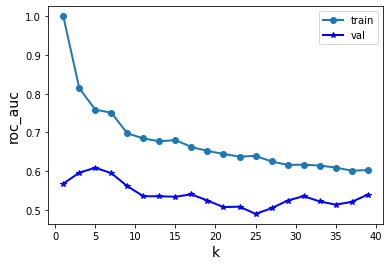

Mayor valor de la figura de mérito en validación con características estandarizadas: 0.609
Valor correspondiente para el hiperparámetro: {'n_neighbors': 5}


In [ ]:
knn('roc_auc')

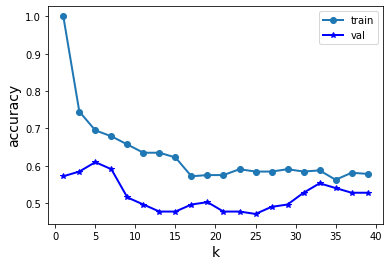

Mayor valor de la figura de mérito en validación con características estandarizadas: 0.610
Valor correspondiente para el hiperparámetro: {'n_neighbors': 5}


In [ ]:
knn('accuracy')

In [ ]:
kNN_clasif_all = KNeighborsClassifier(n_neighbors = 5)
modelo_knn_clasif2 = kNN_clasif_all.fit(X_std_train2, Y_train) 
y_output_knn2 = modelo_knn_clasif2.predict(X_std_test2)
A1_score = accuracy_score(Y_test, y_output_knn2)
f11_score = f1_score(Y_test, y_output_knn2)
r1_score = recall_score(Y_test, y_output_knn2)
MSE1_score = mean_squared_error(Y_test, y_output_knn2)

print("El valor de accuracy obtenido:", A1_score)
print("La matriz de confusión obtenida:", confusion_matrix(Y_test, y_output_knn2))
print("El valor de f1_score obtenido:", f11_score)
print("El valor de recall es", r1_score)
# print("El error cuadrático medio", MSE1_score) 

El valor de accuracy obtenido: 0.525
La matriz de confusión obtenida: [[10  5]
 [14 11]]
El valor de f1_score obtenido: 0.5365853658536586
El valor de recall es 0.44


In [ ]:

A1_score = accuracy_score(Y_test, y_output_knn2)
f11_score = f1_score(Y_test, y_output_knn2)
r1_score = recall_score(Y_test, y_output_knn2)
fpr, tpr, threshold = metrics.roc_curve(Y_test, y_output_knn2)
roc_auc_1 = metrics.auc(fpr, tpr)
print("El valor de accuracy obtenido:", A1_score)
print("La matriz de confusión obtenida:", confusion_matrix(Y_test, y_output_knn2))
print("El valor de f1_score obtenido:", f11_score)
print("El valor de recall es", r1_score)

El valor de accuracy obtenido: 0.525
La matriz de confusión obtenida: [[10  5]
 [14 11]]
El valor de f1_score obtenido: 0.5365853658536586
El valor de recall es 0.44


In [ ]:
res_accuracy.append(A1_score)
res_recall.append(r1_score)
res_f1.append(f11_score)
res_roc.append(roc_auc_1)

# ***ÁRBOLES***

Para los árboles no hace falta la normalización

In [ ]:
from sklearn.tree import DecisionTreeClassifier

def arbol(figura):
  # 1. Selección de hiper-parámetros del árbol. En principio, consideraremos sólo la profundidad máxima
  param_grid = {'max_depth': range(1,5)}
  profundidad_grid = np.array(range(1,5))


  grid_arbol_clasif = GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid = param_grid, scoring = figura, cv=3, return_train_score=True)
  modelo_arbol_clasif = grid_arbol_clasif.fit(X_train, Y_train)
  print(grid_arbol_clasif.best_params_)

  perf_train_arbol = np.array(grid_arbol_clasif.cv_results_['mean_train_score'])
  perf_val_arbol = np.array(grid_arbol_clasif.cv_results_['mean_test_score'])

  plt.plot(profundidad_grid,perf_train_arbol,'-o',label="train", linewidth=2)
  plt.plot(profundidad_grid,perf_val_arbol,'-*b',label="val", linewidth=2)
  plt.xlabel('Profundidad',fontsize=14)
  plt.ylabel(figura,fontsize=14)
  plt.legend()
  plt.show()

  print("Mejor valor de la figura de mérito en validación cruzada: {:.3f}".format(grid_arbol_clasif.best_score_))
  print("Mejor valor del hiperparámetro: {}".format(grid_arbol_clasif.best_params_))


{'max_depth': 4}


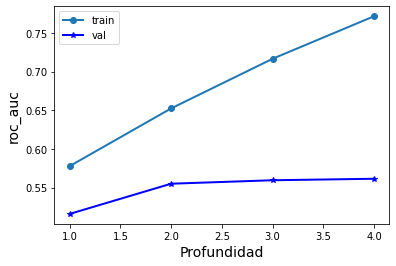

Mejor valor de la figura de mérito en validación cruzada: 0.561
Mejor valor del hiperparámetro: {'max_depth': 4}


In [ ]:
arbol('roc_auc')

{'max_depth': 3}


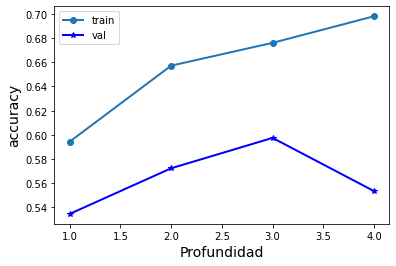

Mejor valor de la figura de mérito en validación cruzada: 0.597
Mejor valor del hiperparámetro: {'max_depth': 3}


In [ ]:
arbol('accuracy')

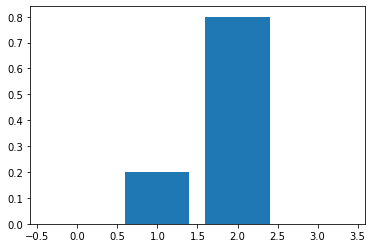

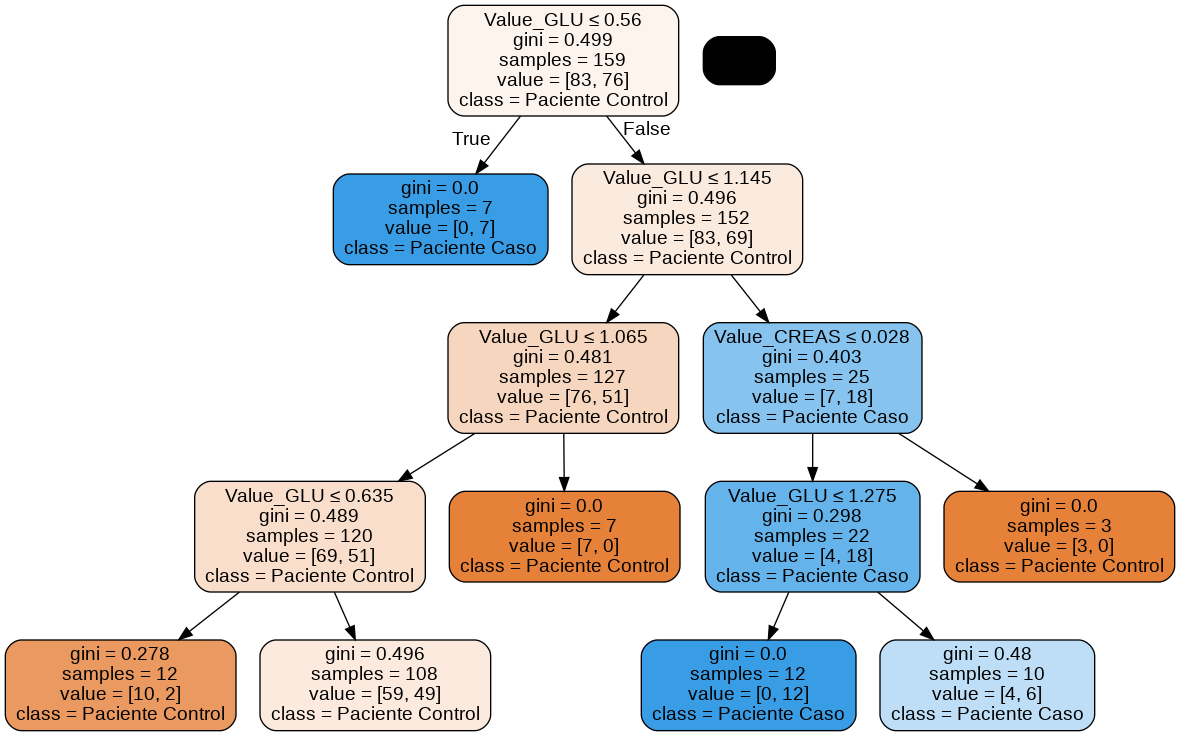

In [ ]:
# 4. Se representa la importancia de cada característica para el árbol diseñado
from matplotlib import pyplot
Arbol_clasif_all = DecisionTreeClassifier(max_depth=4)
modelo_arbol_clasif = Arbol_clasif_all.fit(X_train, Y_train)
y_output_arbol = modelo_arbol_clasif.predict(X_test)
importance_arbol = modelo_arbol_clasif.feature_importances_
pyplot.bar([x for x in range(len(importance_arbol))], importance_arbol)
pyplot.show()

# 5. Se representa gráficamente el modelo de clasificación
from sklearn.tree import export_graphviz
#from sklearn.externals.six import StringIO  
from six import StringIO
from IPython.display import Image  
import pydotplus

dot_data = StringIO()

export_graphviz(modelo_arbol_clasif, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = data_final.columns[1:],class_names=['Paciente Control','Paciente Caso'])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('Tree_Clasif_all.png')
Image(graph.create_png())

In [ ]:

print("El valor de accuracy obtenido:", accuracy_score(Y_test, y_output_arbol))
print("La matriz de confusión obtenida:", confusion_matrix(Y_test, y_output_arbol))
print("El valor de f1_score obtenido:", f1_score(Y_test, y_output_arbol))
print("El valor de recall es", recall_score(Y_test, y_output_arbol))
# print("El error cuadrático medio", mean_squared_error(Y_test, y_output_arbol)) 

# A_results.append(accuracy_score(Y_test2, y_output_arbol))
# f1_results.append(f1_score(Y_test2, y_output_arbol))
# S_results.append(recall_score(Y_test2, y_output_arbol))
# MSE_results.append(mean_squared_error(Y_test2, y_output_arbol))

El valor de accuracy obtenido: 0.45
La matriz de confusión obtenida: [[12  3]
 [19  6]]
El valor de f1_score obtenido: 0.3529411764705882
El valor de recall es 0.24


In [ ]:

A1_score = accuracy_score(Y_test, y_output_arbol)
f11_score = f1_score(Y_test, y_output_arbol)
r1_score = recall_score(Y_test, y_output_arbol)
fpr, tpr, threshold = metrics.roc_curve(Y_test, y_output_arbol)
roc_auc_1 = metrics.auc(fpr, tpr)
print("El valor de accuracy obtenido:", A1_score)
print("La matriz de confusión obtenida:", confusion_matrix(Y_test, y_output_arbol))
print("El valor de f1_score obtenido:", f11_score)
print("El valor de recall es", r1_score)

El valor de accuracy obtenido: 0.45
La matriz de confusión obtenida: [[12  3]
 [19  6]]
El valor de f1_score obtenido: 0.3529411764705882
El valor de recall es 0.24


In [ ]:
res_accuracy.append(A1_score)
res_recall.append(r1_score)
res_f1.append(f11_score)
res_roc.append(roc_auc_1)

# ***SVC***

In [ ]:
from sklearn.svm import SVC


In [ ]:
# Regresión logística con regularización 
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection   
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV

svc=SVC(decision_function_shape='ovo')

# logreg= LogisticRegression(solver='liblinear')
parameters = {'kernel': ['rbf','poly'], 'gamma': [1e-2, 1e-3, 1e-4, 1e-5],
                     'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]}# l1 lasso l2 ridge
# valor_C=np.array([1e-8,1e-4,1,10,100])
svc=GridSearchCV(svc, parameters, scoring='roc_auc', cv=5, return_train_score=True)

svc.fit(X_std_train2, Y_train) #Entrenamos

# #Evaluamos las prestaciones para el conjunto de entrenamiento, de validación y representamos
roc_log_train = np.array(svc.cv_results_['mean_train_score']) 
roc_loc_val = np.array(svc.cv_results_['mean_test_score'])

# #Pintamos la evolución de nuestro modelo tanto en train como en validación para ver cuál es el mejor hiperparámetro para generalizar
# plt.plot(valor_C,roc_log_train,'-o',label="train", linewidth=2)
# plt.plot(valor_C,roc_loc_val,'-*b',label="val", linewidth=2)
# plt.xlabel('C',fontsize=14)
# plt.ylabel('Roc_auc',fontsize=14)
# plt.legend()
# plt.show()

# Mostramos el mejor valor del parámetro y el score
print("Valor correspondiente para el hiperparámetro: {}".format(svc.best_params_))
print("Mayor valor de la figura de mérito en validación con características estandarizadas: {:.3f}".format(svc.best_score_))


Valor correspondiente para el hiperparámetro: {'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}
Mayor valor de la figura de mérito en validación con características estandarizadas: 0.610


In [ ]:


svc=SVC(C=1000,kernel='rbf',gamma=0.01,decision_function_shape='ovo')
svc.fit(X_std_train2,Y_train)
y_test_pred=svc.predict(X_std_test2)

In [ ]:
A1_score = accuracy_score(Y_test, y_test_pred)
f11_score = f1_score(Y_test, y_test_pred)
r1_score = recall_score(Y_test, y_test_pred)

print("El valor de accuracy obtenido:", A1_score)
print("La matriz de confusión obtenida:", confusion_matrix(Y_test, y_test_pred))
print("El valor de f1_score obtenido:", f11_score)
print("El valor de recall es", r1_score)

El valor de accuracy obtenido: 0.425
La matriz de confusión obtenida: [[ 9  6]
 [17  8]]
El valor de f1_score obtenido: 0.41025641025641024
El valor de recall es 0.32


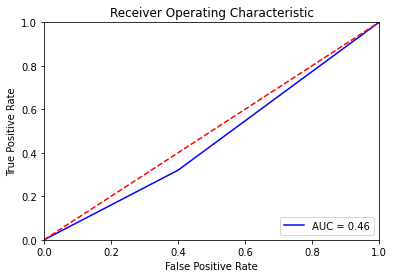

In [ ]:
fpr, tpr, threshold = metrics.roc_curve(Y_test, y_test_pred)
roc_auc_1 = metrics.auc(fpr, tpr)
# AUC_results.append(roc_auc_1)

# Plot the ROC curve
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
res_accuracy.append(A1_score)
res_recall.append(r1_score)
res_f1.append(f11_score)
res_roc.append(roc_auc_1)

In [ ]:
results = pd.DataFrame()

results["Accuracy"]=res_accuracy
results["Recall"]=res_recall
results["F1-score"]=res_f1
results["Auc"]=res_roc

#results
results["Modelos"] = ["Regresión logística", "Knn","Árbol","SVC"]
results.set_index("Modelos", inplace = True)

In [ ]:
results

,Accuracy,Recall,F1-score,Auc
Modelos,,,,
Regresión logística,0.650,0.64,0.695652,0.653333
Knn,0.525,0.44,0.536585,0.553333
Árbol,0.450,0.24,0.352941,0.520000
SVC,0.425,0.32,0.410256,0.460000


# **MÉTODO ENSEMBLE**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
def RandomForest(figura):
  # 1. Extracción de las dos características de interés para realizar el diseño

  param_grid = {'n_estimators': [10, 20, 30, 40, 50, 100]}
  arboles_grid=[10, 20, 30, 40, 50, 100]

  CV_rfc = GridSearchCV(RandomForestClassifier(max_features= 'sqrt'), param_grid=param_grid, cv= 5, n_jobs=-1, scoring=figura, return_train_score=True)
  CV_rfc.fit(X_std_train2, Y_train)
  print(CV_rfc.best_params_)

  perf_train_rfc = np.array(CV_rfc.cv_results_['mean_train_score'])
  perf_val_rfc = np.array(CV_rfc.cv_results_['mean_test_score'])

  plt.plot(arboles_grid,perf_train_rfc,'-o',label="train", linewidth=2)
  plt.plot(arboles_grid,perf_val_rfc,'-*b',label="val", linewidth=2)
  plt.xlabel('Arboles',fontsize=14)
  plt.ylabel(figura,fontsize=14)
  plt.legend()
  plt.show()


  print("Mejor MSE en validación cruzada: {:.3f}".format(CV_rfc.best_score_))
  print("Mejor valor del hiperparámetro: {}".format(CV_rfc.best_params_))


{'n_estimators': 20}


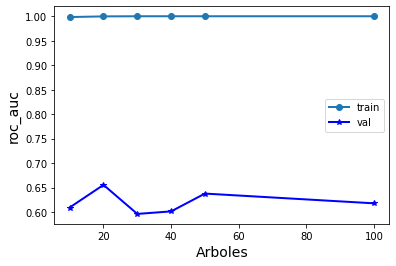

Mejor MSE en validación cruzada: 0.655
Mejor valor del hiperparámetro: {'n_estimators': 20}


In [ ]:

RandomForest('roc_auc')

{'n_estimators': 100}


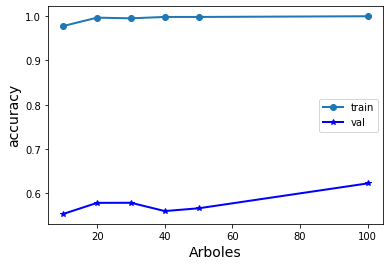

Mejor MSE en validación cruzada: 0.622
Mejor valor del hiperparámetro: {'n_estimators': 100}


In [ ]:
RandomForest('accuracy')

In [ ]:
RF_clasif_all = RandomForestClassifier(n_estimators=50)
modelo_RF_clasif2 = RF_clasif_all.fit(X_std_train2, Y_train) 
y_output_RF = modelo_RF_clasif2.predict(X_std_test2)
print(accuracy_score(Y_test, y_output_RF))
print(confusion_matrix(Y_test, y_output_RF))
print(f1_score(Y_test, y_output_RF))
print(recall_score(Y_test, y_output_RF))

# A_results.append(accuracy_score(Y_test2, y_output_RF))
# f1_results.append(f1_score(Y_test2, y_output_RF))
# S_results.append(recall_score(Y_test2, y_output_RF))
# MSE_results.append(mean_squared_error(Y_test2, y_output_RF))

0.575
[[11  4]
 [13 12]]
0.5853658536585366
0.48


# ***REEMPLAZO DE VALORES NULOS POR MEDIA, MODA***

In [ ]:
X_train.isna().sum()

Value_HBA1C    0
Value_CPEP     1
Value_CREAS    1
Value_GLU      1
dtype: int64

In [ ]:
X_test.isna().sum()

Value_HBA1C    0
Value_CPEP     1
Value_CREAS    1
Value_GLU      1
dtype: int64

Vemos que existen los valores nulos vistos anteriormente en el preprocesado. A continuación, imputaremos los valores NaN calculando la media del conjunto de 
train y aplicacándolos tanto al conjunto de train como al conjunto de test:

In [ ]:
media_CPEP=X_train["Value_CPEP"].mean()
print(media_CPEP)
media_GLU=X_train["Value_GLU"].mean()
print(media_GLU)
media_HBA1C=X_train["Value_HBA1C"].mean()
print(media_HBA1C)
media_CREAS=X_train["Value_CREAS"].mean()
print(media_CREAS)

0.05058860759493675
180.18987341772151
7.684276729559746
0.9016455696202529


In [ ]:
X_train["Value_CPEP"].replace(np.nan, media_CPEP, inplace=True)
X_test["Value_CPEP"].replace(np.nan, media_CPEP, inplace=True)

X_train["Value_GLU"].replace(np.nan, media_GLU, inplace=True)
X_test["Value_GLU"].replace(np.nan, media_GLU, inplace=True)

X_train["Value_HBA1C"].replace(np.nan, media_HBA1C, inplace=True)
X_test["Value_HBA1C"].replace(np.nan, media_HBA1C, inplace=True)

X_train["Value_CREAS"].replace(np.nan, media_CREAS, inplace=True)
X_test["Value_CREAS"].replace(np.nan, media_CREAS, inplace=True)

In [ ]:
X_train.isna().sum()

Value_HBA1C    0
Value_CPEP     0
Value_CREAS    0
Value_GLU      0
dtype: int64

In [ ]:
X_test.isna().sum()

Value_HBA1C    0
Value_CPEP     0
Value_CREAS    0
Value_GLU      0
dtype: int64

Vemos que ya no hay valores perdidos ni en train ni en test

In [ ]:
# import pandas as pd
# from scipy import stats

# for i in X_train, X_test:
#   try:
#     z_scores1 = stats.zscore(X_train[i])
#     abs_z_scores1 = np.abs(z_scores1)
#     outliers1 = (abs_z_scores1 > 2)
#     X_train[i] = X_train[i].where(~(outliers1), X_train[i].mean())

#     z_scores2 = stats.zscore(X_test[i])
#     abs_z_scores2 = np.abs(z_scores2)
#     outliers2 = (abs_z_scores2 > 2)
#     X_test[i] = X_test[i].where(~(outliers2), X_train[i].mean())

#   except:
#     print(i, ": No existen outliers")

A continuación, balancearemos las clases de pacientes caso y pacientes control, para que no se produzca ese sesgo a la hora de crear el modelo:

In [ ]:
# from imblearn.over_sampling import RandomOverSampler
# from collections import Counter

# oversample = RandomOverSampler(sampling_strategy='minority')
# X_train_over, Y_train_over = oversample.fit_resample(X_train, Y_train)
# print(Counter(Y_train_over))

Vamos a pintarlo para ver mejor ese balanceo:

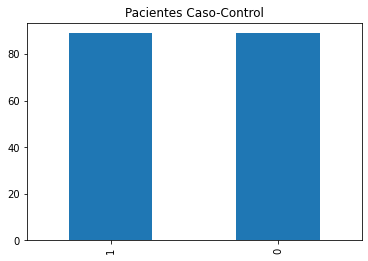

In [ ]:
# Y_train_over.value_counts().plot.bar(title="Pacientes Caso-Control")

Ya tenemos ambas clases balanceadas

A continuación, estadarizamos el conjunto de train y test:

In [ ]:

from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing


std_all = preprocessing.StandardScaler().fit(X_train)
X_std_train = std_all.transform(X_train) #Tendriamos todas las características estandarizadas
X_std_test = std_all.transform(X_test)

Vemos que la variable que más está influyendo es el porcentaje total del cuestionario realizado.



# ***CLASIFICACIÓN***

# ***REGRESIÓN LOGÍSTICA CON REGULARIZACIÓN***

In [ ]:
# Regresión logística con regularización 
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection   
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV

logreg= LogisticRegression(solver='liblinear')
parameters = {"C":[1e-8,1e-4,10,100],"penalty":["l1","l2"]}# l1 lasso l2 ridge
valor_C=np.array([1e-8,1e-4,10,100])
log_regression=GridSearchCV(logreg, parameters, scoring='roc_auc', cv=5, return_train_score=True)

log_regression.fit(X_std_train, Y_train) #Entrenamos

# #Evaluamos las prestaciones para el conjunto de entrenamiento, de validación y representamos
roc_log_train = np.array(log_regression.cv_results_['mean_train_score']) 
roc_loc_val = np.array(log_regression.cv_results_['mean_test_score'])

# #Pintamos la evolución de nuestro modelo tanto en train como en validación para ver cuál es el mejor hiperparámetro para generalizar
# plt.plot(valor_C,roc_log_train,'-o',label="train", linewidth=2)
# plt.plot(valor_C,roc_loc_val,'-*b',label="val", linewidth=2)
# plt.xlabel('C',fontsize=14)
# plt.ylabel('Roc_auc',fontsize=14)
# plt.legend()
# plt.show()

# Mostramos el mejor valor del parámetro y el score
print("Valor correspondiente para el hiperparámetro: {}".format(log_regression.best_params_))
print("Mayor valor de la figura de mérito en validación con características estandarizadas: {:.3f}".format(log_regression.best_score_))






Valor correspondiente para el hiperparámetro: {'C': 10, 'penalty': 'l2'}
Mayor valor de la figura de mérito en validación con características estandarizadas: 0.559


A continuación, ya construimos nuestro modelo con los parámetros obtenidos a partir de validación cruzada y es con un valor de C=10 y un modelo lasso. Así obtenemos los resultados obtenidos en el conjunto de test:

In [ ]:
from sklearn.linear_model import Lasso

logridge=LogisticRegression(solver='liblinear', penalty='l2', C=10)
modelo_rid_log=logridge.fit(X_std_train, Y_train)

# Obtenemos la salida predicha
y_pred_ridlog = modelo_rid_log.predict(X_std_test)




A continuación, vamos a calcular diferentes figuras de mérito para ver que resultados obtenemos en test. Comenzamos con la matriz de confusión:

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score

#  Calculamos la matriz de confusión
cm = confusion_matrix(Y_test, y_pred_ridlog)
print(cm)

tn, fp, fn, tp = confusion_matrix(Y_test, y_pred_ridlog).ravel()
print(f'tn: {tn}, fp:{fp}, fn:{fn}, tp:{tp}')

# Calcumos accuracy_score
Accuracy=accuracy_score(Y_test, y_pred_ridlog)
print(f'Accuracy: {Accuracy}')

target_names = ['Paciente control', 'Paciente caso']
print(classification_report(Y_test, y_pred_ridlog, target_names=target_names))
              
#Sensibilidad
Sensibilidad_3 = recall_score(Y_test, y_pred_ridlog)
# S_results.append(Sensibilidad_3)
print(f'Sensibilidad: {Sensibilidad_3}')

[[10  5]
 [ 9 16]]
tn: 10, fp:5, fn:9, tp:16
Accuracy: 0.65
                  precision    recall  f1-score   support

Paciente control       0.53      0.67      0.59        15
   Paciente caso       0.76      0.64      0.70        25

        accuracy                           0.65        40
       macro avg       0.64      0.65      0.64        40
    weighted avg       0.67      0.65      0.66        40

Sensibilidad: 0.64


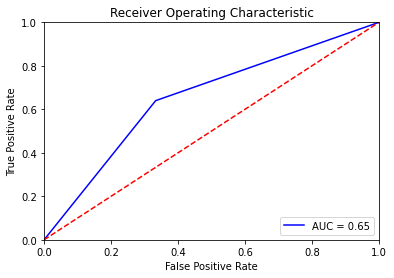

In [ ]:
fpr, tpr, threshold = metrics.roc_curve(Y_test, y_pred_ridlog)
roc_auc_1 = metrics.auc(fpr, tpr)
# AUC_results.append(roc_auc_1)

# Plot the ROC curve
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# **Knn por votación**

In [ ]:

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
#from mlxtend.plotting import plot_learning_curves

In [ ]:
def knn (figura):
  # 5. Selección del hiper-parámetro haciendo uso del conjunto de diseño con características estandarizadas. 

  param_grid = {'n_neighbors': range(1,61,2)}
  k_grid = np.array(range(1,61,2))
  grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid = param_grid, scoring = figura, cv=3, return_train_score=True)
  grid_knn.fit(X_std_train, Y_train) 

  #Evaluamos las prestaciones para el conjunto de entrenamiento, de validación y representamos
  
  auc_knn_all_train = np.array(grid_knn.cv_results_['mean_train_score'])
  auc_knn_all_val = np.array(grid_knn.cv_results_['mean_test_score'])


  plt.plot(k_grid,auc_knn_all_train,'-o',label="train", linewidth=2)
  plt.plot(k_grid,auc_knn_all_val,'-*b',label="val", linewidth=2)
  plt.xlabel('k',fontsize=14)
  plt.ylabel(figura,fontsize=14)
  plt.legend()
  plt.show()

  print("Mayor valor de la figura de mérito en validación con características estandarizadas: {:.3f}".format(grid_knn.best_score_))
  print("Valor correspondiente para el hiperparámetro: {}".format(grid_knn.best_params_))

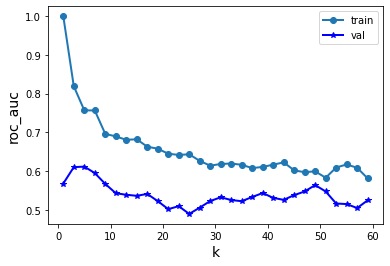

Mayor valor de la figura de mérito en validación con características estandarizadas: 0.611
Valor correspondiente para el hiperparámetro: {'n_neighbors': 5}


In [ ]:
knn('roc_auc')

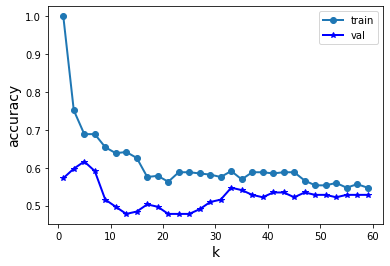

Mayor valor de la figura de mérito en validación con características estandarizadas: 0.616
Valor correspondiente para el hiperparámetro: {'n_neighbors': 5}


In [ ]:
knn('accuracy')

Podemos observar según la curva de validación que podríamos elegir un número de vecinos igual a 5

Con este valor elegido de k, vamos a determinar  los valores de 4 figuras de mérito para estimar las prestaciones sobre un conjunto de test independiente del utilizado en el diseño:


In [ ]:
kNN_clasif_all = KNeighborsClassifier(n_neighbors = 5)
modelo_knn_clasif2 = kNN_clasif_all.fit(X_std_train, Y_train) 
y_output_knn2 = modelo_knn_clasif2.predict(X_std_test)
A1_score = accuracy_score(Y_test, y_output_knn2)
f11_score = f1_score(Y_test, y_output_knn2)
r1_score = recall_score(Y_test, y_output_knn2)

print("El valor de accuracy obtenido:", A1_score)
print("La matriz de confusión obtenida:", confusion_matrix(Y_test, y_output_knn2))
print("El valor de f1_score obtenido:", f11_score)
print("El valor de recall es", r1_score)


El valor de accuracy obtenido: 0.5
La matriz de confusión obtenida: [[10  5]
 [15 10]]
El valor de f1_score obtenido: 0.5
El valor de recall es 0.4


# ***ÁRBOLES***

Para los árboles no hace falta la normalización

In [ ]:
from sklearn.tree import DecisionTreeClassifier

def arbol(figura):
  # 1. Selección de hiper-parámetros del árbol. En principio, consideraremos sólo la profundidad máxima
  param_grid = {'max_depth': range(1,5)}
  profundidad_grid = np.array(range(1,5))


  grid_arbol_clasif = GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid = param_grid, scoring = figura, cv=3, return_train_score=True)
  modelo_arbol_clasif = grid_arbol_clasif.fit(X_train, Y_train)
  print(grid_arbol_clasif.best_params_)

  perf_train_arbol = np.array(grid_arbol_clasif.cv_results_['mean_train_score'])
  perf_val_arbol = np.array(grid_arbol_clasif.cv_results_['mean_test_score'])

  plt.plot(profundidad_grid,perf_train_arbol,'-o',label="train", linewidth=2)
  plt.plot(profundidad_grid,perf_val_arbol,'-*b',label="val", linewidth=2)
  plt.xlabel('Profundidad',fontsize=14)
  plt.ylabel(figura,fontsize=14)
  plt.legend()
  plt.show()

  print("Mejor valor de la figura de mérito en validación cruzada: {:.3f}".format(grid_arbol_clasif.best_score_))
  print("Mejor valor del hiperparámetro: {}".format(grid_arbol_clasif.best_params_))


{'max_depth': 4}


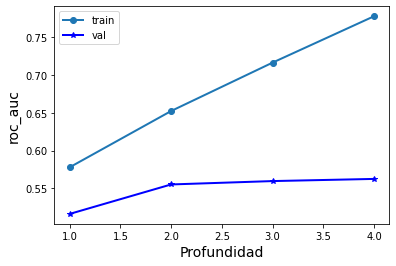

Mejor valor de la figura de mérito en validación cruzada: 0.562
Mejor valor del hiperparámetro: {'max_depth': 4}


In [ ]:
arbol('roc_auc')

{'max_depth': 3}


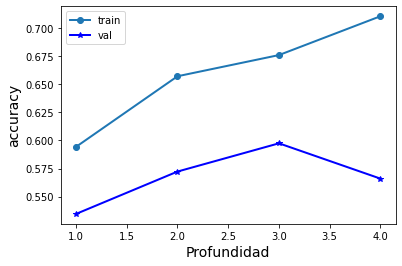

Mejor valor de la figura de mérito en validación cruzada: 0.597
Mejor valor del hiperparámetro: {'max_depth': 3}


In [ ]:
arbol('accuracy')

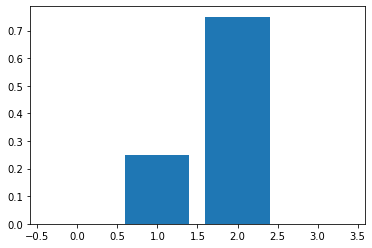

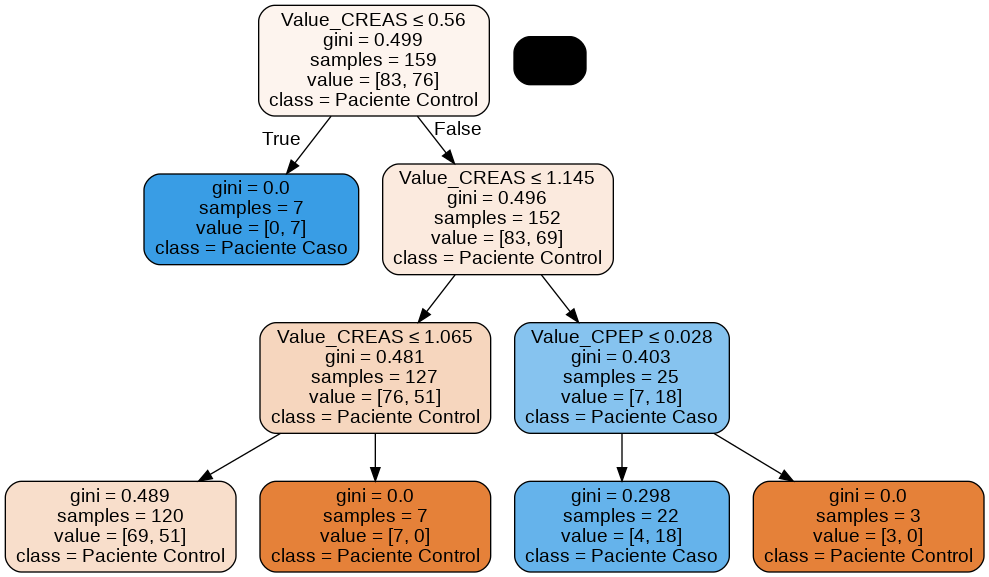

In [ ]:
# 4. Se representa la importancia de cada característica para el árbol diseñado
from matplotlib import pyplot
Arbol_clasif_all = DecisionTreeClassifier(max_depth=3)
modelo_arbol_clasif = Arbol_clasif_all.fit(X_train, Y_train)
y_output_arbol = modelo_arbol_clasif.predict(X_test)
importance_arbol = modelo_arbol_clasif.feature_importances_
pyplot.bar([x for x in range(len(importance_arbol))], importance_arbol)
pyplot.show()

# 5. Se representa gráficamente el modelo de clasificación
from sklearn.tree import export_graphviz
#from sklearn.externals.six import StringIO  
from six import StringIO
from IPython.display import Image  
import pydotplus

dot_data = StringIO()

export_graphviz(modelo_arbol_clasif, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = data_final.columns[0:-1],class_names=['Paciente Control','Paciente Caso'])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('Tree_Clasif_all.png')
Image(graph.create_png())

In [ ]:
print("El valor de precisión obtenido:", accuracy_score(Y_test, y_output_arbol))
print("La matriz de confusión obtenida:", confusion_matrix(Y_test, y_output_arbol))
print("El valor de f1_score obtenido:", f1_score(Y_test, y_output_arbol))
print("El valor de sensibilidad es", recall_score(Y_test, y_output_arbol))

# A_results.append(accuracy_score(Y_test2, y_output_arbol))
# f1_results.append(f1_score(Y_test2, y_output_arbol))
# S_results.append(recall_score(Y_test2, y_output_arbol))
# MSE_results.append(mean_squared_error(Y_test2, y_output_arbol))

El valor de precisión obtenido: 0.45
La matriz de confusión obtenida: [[12  3]
 [19  6]]
El valor de f1_score obtenido: 0.3529411764705882
El valor de sensibilidad es 0.24


# **MÉTODO ENSEMBLE**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
def RandomForest(figura):
  # 1. Extracción de las dos características de interés para realizar el diseño

  param_grid = {'n_estimators': [10, 20, 30, 40, 50, 100]}
  arboles_grid=[10, 20, 30, 40, 50, 100]

  CV_rfc = GridSearchCV(RandomForestClassifier(max_features= 'sqrt'), param_grid=param_grid, cv= 5, n_jobs=-1, scoring=figura, return_train_score=True)
  CV_rfc.fit(X_std_train, Y_train)
  print(CV_rfc.best_params_)

  perf_train_rfc = np.array(CV_rfc.cv_results_['mean_train_score'])
  perf_val_rfc = np.array(CV_rfc.cv_results_['mean_test_score'])

  plt.plot(arboles_grid,perf_train_rfc,'-o',label="train", linewidth=2)
  plt.plot(arboles_grid,perf_val_rfc,'-*b',label="val", linewidth=2)
  plt.xlabel('Arboles',fontsize=14)
  plt.ylabel(figura,fontsize=14)
  plt.legend()
  plt.show()


  print("Mejor MSE en validación cruzada: {:.3f}".format(CV_rfc.best_score_))
  print("Mejor valor del hiperparámetro: {}".format(CV_rfc.best_params_))


{'n_estimators': 40}


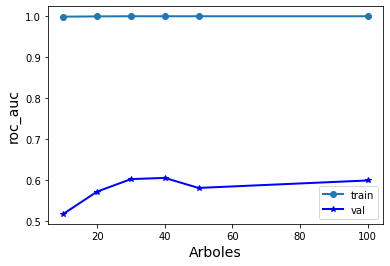

Mejor MSE en validación cruzada: 0.606
Mejor valor del hiperparámetro: {'n_estimators': 40}


In [ ]:
RandomForest('roc_auc')

{'n_estimators': 30}


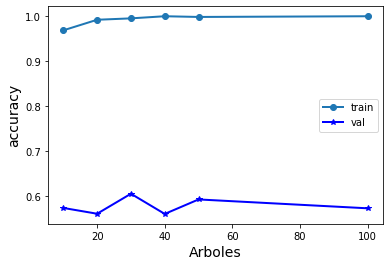

Mejor MSE en validación cruzada: 0.604
Mejor valor del hiperparámetro: {'n_estimators': 30}


In [ ]:
RandomForest('accuracy')

In [ ]:
RF_clasif_all = RandomForestClassifier(n_estimators=30,max_features= 'sqrt')
modelo_RF_clasif2 = RF_clasif_all.fit(X_std_train, Y_train) 
y_output_RF = modelo_RF_clasif2.predict(X_std_test)
print(accuracy_score(Y_test, y_output_RF))
print(confusion_matrix(Y_test, y_output_RF))
print(f1_score(Y_test, y_output_RF))
print(recall_score(Y_test, y_output_RF))

# A_results.append(accuracy_score(Y_test2, y_output_RF))
# f1_results.append(f1_score(Y_test2, y_output_RF))
# S_results.append(recall_score(Y_test2, y_output_RF))
# MSE_results.append(mean_squared_error(Y_test2, y_output_RF))

0.475
[[10  5]
 [16  9]]
0.4615384615384615
0.36
